In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

In [2]:
words = open("data/kharpathy/names.txt", "r").read().splitlines()

In [3]:
uniques_characters = sorted(set(''.join(words)))
itos = {idx+1:uniq_char for idx, uniq_char in enumerate(uniques_characters)}
itos[0] = '.'

stoi = {v:k for k,v in itos.items()}

print(itos)
print(stoi)

VOCABULARY_SIZE = len(stoi.items())
print(f"Uniques tokens in dataset: {VOCABULARY_SIZE}")

BLOCK_SIZE = 3
print(f"Number of characters used as context in the inputs: {BLOCK_SIZE}")

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
Uniques tokens in dataset: 27
Number of characters used as context in the inputs: 3


In [4]:
def build_dataset(dataset_words):
  """
  This function receive a list of words and return the both samples tensors:
  * X tensor with the inputs (the indexes of the character's sequence)
  * Y tensor with the labels (the indexes of the actual character that follows the sequence)
  """
  X, Y = [], []

  for word in dataset_words:
    input = [0]*BLOCK_SIZE
    for ch in word+'.':
      ch_ix = stoi[ch]
      X.append(input.copy())
      Y.append(ch_ix)
      input = input[1:] + [ch_ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  return X, Y

import random
random.seed(42)
random.shuffle(words)

# Now we need to calculate the starting and the ending indexes for every split
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

print(f"Samples in train split: {Ytr.shape[0]}")
print(f"Samples in train split: {Ydev.shape[0]}")
print(f"Samples in train split: {Ytest.shape[0]}")

Samples in train split: 182625
Samples in train split: 22655
Samples in train split: 22866


Now we we are going to create a new function `cmp`. This new function will compare the gradients calculated by pytorch and the gradients derived by us:

In [5]:
def cmp(s, dt, t):
  """
  dt is the gradients tensor that we have calculated by hand
  t is the tensor from which we want that pytorch calculate the tensor for us
    (that's why later in the function we will call t.grad)
  """
  # Check if the manual gradient and the pytorch one is exactly equal element by
  # element, 'ex' will store True or False
  ex = torch.all(dt == t.grad).item()

  # Check if all the elements between the manual gradient and the pytorch one
  # are at least very similar, 'app' will be True or False
  app = torch.allclose(dt, t.grad)

  # We store in maxdiff the maximum different between two equivalents values (values
  # in the same position) in both tensors
  maxdiff = (dt - t.grad).abs().max().item()

  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

Now is the time to implement our neural network:

In [7]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 64 # the number of neurons in the hidden layers of the MLP

# Random seed for reproducibility
g = torch.Generator().manual_seed(2147483647)

# Embeddings matrix, as many rows as uniques tokens (or vocabulary tokens)
# so each row represent one embedding token, and as many columns as embedding
# dimensionality
C = torch.randn((VOCABULARY_SIZE, n_embd), generator = g)

### GENERAL IMPLEMENTATION NOTE ###
# We do not have initialized any layer with 0s because this can mask some
# gradients error because they are going to be all zeros, so to make sure that
# we always calculate correctly the gradient we initialize them random and
# muliply by 0.1. In the layer that should be initialized to one we use the same
# strategy as before but we add 1.0

#### Layer 1 ####
# Multiplicative tensor for the first hidden layer, we also include the gain
# that ensure the gaussian distribution after the later relu activation layer
W1 = torch.randn((n_embd * BLOCK_SIZE, n_hidden), generator=g) * (5/3)/((n_embd * BLOCK_SIZE)**0.5)
# b1 will be applied to the ouptut of the multiplication so we need as many cells
# as neurons in the output. As we have seen in previous notebooks this bias
# is not going to do nothing because the batchnorm later will cancel the effect
# but we will keep it as an exercises to calculate the gradient
b1 = torch.randn(n_hidden,                        generator=g)
#################

#### Layer 2 ####
W2 = torch.randn((n_hidden, VOCABULARY_SIZE),     generator=g)
b2 = torch.randn(VOCABULARY_SIZE,                 generator=g)
#################

#### BatchNorm parameters (scale and shift) ####
bngain = torch.randn(1, n_hidden) * 0.1 + 1.0
bnbias = torch.randn(1, n_hidden) * 0.1
################################################

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print("Trainable params:",sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

Trainable params: 4137


Now we build one minibatch to do a forward pass and start calculating gradients

In [7]:
batch_size = 32
n = batch_size

batch_ixs = torch.randint(low=0,high=Ytr.shape[0], size=(n,), generator = g)
Xb, Yb = Xtr[batch_ixs], Ytr[batch_ixs]

print(Xb.shape)
print(Yb.shape)

torch.Size([32, 3])
torch.Size([32])


In the following cell we are going to perform a forward pass through our network. We have separated or chunckated all the intermediate steps to be able to calculate the gradients in this intermediates tensors or results.

In [9]:
emb = C[Xb] # Get the embedings of each token: C.shape = (27, 10), Xb.shape = (32, 3), emb.shape = (32, 3, 10)

embcat = emb.view(n, -1) # concatenate the vectors to obtain one row per sample: embcat.shape = (32, 30)

# Linear layer 1
hprebn = embcat @ W1 + b1 # First hidden layer:
                          # embcat.shape = (32, 30),
                          # W1.shape = (30, 64),
                          # b1.shape = (1, 64),
                          # hprebn.shape = (32, 64)

# BatchNorm layer

# bnmeani is the mean accross the samples for each hidden dimension
bnmeani = hprebn.sum(0, keepdim=True) * (1/n) # hprebn.sum(0, keepdim=True).shape = (1, 64)
                                              # bnmeani.shape = (1, 64)
bndiff = (hprebn - bnmeani) # bnmeani.shape = (1, 64),
                            # hprebn.shape = (32, 64)
                            # bndiff.shape = (32, 64)
                            # bnmeani need to broadcast the values replicating the 64 values for each on of the 32 rows
                            # so all elements found in the same column (in hprebn) are subtracted by the same number

bndiff2 = bndiff**2         # bndiff.shape = (32, 64)
                            # bndiff2 = (32, 64)

bnvar = (1.0/(n-1))*bndiff2.sum(0, keepdim=True)    # The variance is calculated as: var = (1/n)*sum((x-mean)^2) so here we go.
                                                    # Here we are using the Bessel's correction
                                                    # bndiff2.sum(0, keepdim=True).shape = (1, 64)
                                                    # bnvar.shape = (1, 64)

bnvar_inv = (bnvar + 1e-5)**-0.5                    # In this line we are calulating the inverse square root of the variance
                                                    # We are adding the 1e-5 term to avoid numerical issues if any element in
                                                    # some element in bnvar is exactly 0
                                                    # bnvar.shape = (1, 64)
                                                    # bnvar_inv.shape = (1, 64)

bnraw = bndiff * bnvar_inv                          # bnraw will follow a standard distribution (across columns) ie. every
                                                    # column will follow a standard distribution
                                                    # bndiff.shape = (32, 64)
                                                    # bnvar_inv.shape = (1, 64)
                                                    # bnraw.shape = (32, 64)

hpreact = bngain * bnraw + bnbias                   # Now we will apply the scale and shift to the bnraw tensor
                                                    # this will give flexibility to the distribution in every column
                                                    # bnraw.shape = (32, 64)
                                                    # bngain.shape = (1, 64)
                                                    # bnbias.shape = (1, 64)
                                                    # hpreact.shape = (32, 64)
                                                    # As we can see bngain and bnbias need to broadcast the columns
                                                    # to match the 32 rows (it will replicate the unique rows that they have
                                                    # 32 times)

# Non-linearity layer
h = torch.tanh(hpreact)   # hpreact.shape = (32, 64)
                          # h.shape = (32, 64)

logits = h @ W2 + b2    # Second hidden layer:
                        # h.shape = (32, 64),
                        # W1.shape = (64, 27),
                        # b2.shape = (1, 27),
                        # logits.shape = (32, 27)


#### Cross entropy loss (same as F.cross_entropy(logits, Yb)) ####

# The first step is to calculate the max value on each row to, later, substract it
# from all the elements in the same row to avoid inf error in later exponentiation

logits_maxes, max_ixs = logits.max(dim=1, keepdim=True) # logits_maxes is a tensor with the maximum element of each row
                                                        # logits_maxes.shape = (32, 1)
                                                        # logits.shape = (32, 27)

norm_logits = logits - logits_maxes   # Here we substract from each logit the maximum value in its row
                                      # logits.shape = (32, 27)
                                      # logits_maxes.shape = (32, 1)
                                      # norm_logits.shape = (32, 27)
                                      #
                                      # As we can see logits and logits_maxes do not have the same
                                      # shape, so pytorch needs to broadcast the values in logits_maxes
                                      # to replace the maxes column 27 times, the results will be
                                      # rows of 27 elements all of them the same on each row


counts = norm_logits.exp()    # We are just exponentiating to have nothing but positives numbers
                              # norm_logits.shape = (32, 27)
                              # counts.shape = (32, 27)

counts_sum = counts.sum(1, keepdim=True)  # Now we need to get the sum of all elements in every row
                                          # to later normalize the counts. The result will be a tensor
                                          # with one single element per row, the sum of all the elements in this row
                                          # counts.shape = (32, 27)
                                          # counts_sum.shape = (32, 1)

counts_sum_inv = counts_sum**-1   # Here we are just making the 1/counts_sum to get the variable counts_sum_inv
                                  # that we multiply (divide) to normalize the sounts values
                                  # counts_sum.shape = (32, 1)
                                  # counts_sum_inv.shape = (32, 1)

probs = counts * counts_sum_inv   # Calculate the probs. All elements on every row must sum up 1.
                                  # probs = counts / sum(counts)
                                  # counts.shape = (32, 27)
                                  # counts_sum_inv.shape = (32, 1)
                                  # probs.shape = (32, 27)

logprobs = probs.log()    # We calculate the log of the probability to make the
                          # small probabilities biggers and dont break the floating
                          # point computations. This also let us transform multiplication
                          # in log sumations
                          # probs.shape = (32, 27)
                          # logprobs.shape = (32, 27)

loss = -logprobs[range(n), Yb].mean()   # Now we calculate the mean loss:
                                        # we take all the n (batch_size) rows -> range(n)
                                        # for each row we take just the value in the correct (label) position -> Yb
                                        # Then we calcuate the mean of all this losses (the mean of the samples losses)
                                        # logprobs.shape = (32, 27)
                                        # loss.shape = (1)
##################################################################

# PyTorch backward pass
for p in parameters:
  p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no cleaner way
          norm_logits, logits_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:

  t.retain_grad() # If we do not activate retain_grad on this tensors Pytorch does not keep track
                  # of the grad on this tensor (for example bnvar.grad -> None). This is because
                  # they are not leaf tensor. We can think in leaf tensor like the one that are
                  # not part of the intermediate gradient calculations for example
                  # until we reach the derivative of Loss w.r.t W2 we need to make some
                  # intermediate calculations using the chain rule, this intermediate gradients
                  # are not going to be stored by pytorch unless we set retain_grad

loss.backward()
loss

tensor(10.2184, grad_fn=<NegBackward0>)

## Backpropagating all the intermediates steps manually

### $d\_logprobs =\frac{\partial loss}{\partial logprobs}$

We start calculating the first back derivative the one that relates the changes in `loss` with the changes in `logprobs`. The first thing that we need to take into account as a hint is that `d_logprobs` should have the same shape as `logprobs` because every element (in the general case) in the `logprobs` tensor affect to the loss value, so `d_logprobs.shape == logprobs.shape -> (32, 27)`.

Another point is that, in our case, not all elements in `logprobs` are used to calculate the `loss` value, we can see it in the indexing step `logprobs[range(n), Yb]`, the elements that not are included in this indexing have a derivative of `0` because they do not affect the calculation of the loss.

Now we need to compute the derivative of the elements that actually affect to the loss. They are used to compute a mean value, lets write the formula of the mean and derive its derivatrive (we will replace `logprobs` by `lps` to simplify teh expression):

$mean = \frac{\sum_{l_{ix}}^{n} lps_{l_{ix}}}{n}$

Being:
* $n$: number of samples in the batch (the mean is calculated across all samples in the batch
* $lps_{l_{ix}}$: the logprob value of the character that corresponds to the label in the ${l_{ix}}$ sample.

Nows lets expand the derivative:

$mean = \frac{\sum_{l_{ix}}^{n} lps_{l_{ix}}}{n} = \frac{lps_{0}+lps_{1}+...+lps_{n}}{n}$

and calculate the derivative:

$\frac{\partial mean}{\partial lps_{l_{ix}}} = \frac{\partial loss}{\partial lps_{l_{ix}}} = 0 + ... + \frac{1}{n} + ... + 0 = \frac{1}{n}$

So it seems that the derivative of the loss w.r.t. to each of the `logprobs` element is $\frac{1}{n}$ for all of them.

So lets check it with a simple example:


In [10]:
pre_mean = torch.tensor([1.0, 2.0, 3.0, 4.0])
mean = pre_mean.mean()
print(f"Original mean: {mean}")

pre_mean_inc = torch.tensor([1.0, 2.0 + 1, 3.0, 4.0])
mean_inc = pre_mean_inc.mean()
print(f"Mean after increment: {mean_inc}")

print(f"Increment: {mean_inc - mean}")

n_tmp = pre_mean.numel()
print(f"1/n = {1/n_tmp}")

Original mean: 2.5
Mean after increment: 2.75
Increment: 0.25
1/n = 0.25


As we can see we have reproduced the fact that the derivative (increment with a change of 1 in one of the element) produces an increment in the output of `1/n`. So now lets define `d_logprobs`, the tensor that will store the derivatives for each value of `logprobs`:

In [11]:
# We will start creating a tensor of 0 because most of the logprobs do not
# affect to the loss as we have explained previously
d_logprobs = torch.zeros_like(logprobs)

# Now we replace the values in the relevant position by the 1/n previously explained
# we include the negative symbol because loss = -logprobs...
d_logprobs[range(n), Yb] = -1.0/n

Now let's check that our calculations coincide with those of pytorch:

In [12]:
cmp('d_logprobs', d_logprobs, logprobs)

d_logprobs      | exact: True  | approximate: True  | maxdiff: 0.0


### $d\_probs =\frac{\partial loss}{\partial logprobs} * \frac{\partial logprobs}{\partial probs}$

Here we focus on the $\frac{\partial logprobs}{\partial probs}$ because we have already calculated the other part of the derivative.

We see in the code that `logprobs = probs.log()` so:

$\frac{\partial logprobs}{\partial probs} = \frac{\partial \log_e (probs)}{\partial probs}$

If we take into account that:
$\frac{\partial \log_e(x)}{\partial x} = \frac{1}{x}$

Then we have that:
$\frac{\partial logprobs}{\partial probs} = \frac{1}{probs}$

Because we are just dividing (calculating the inverse of the probs) we don't need to care about shapes or other issues.

We can see this with the following example:

In [13]:
pre_log = torch.tensor([3.0])
print(f"Original: {pre_log}")

post_log = pre_log.log()
print(f"After log: {post_log}")

# Apply a small increment
inc = 0.01
pre_log_inc = pre_log + inc
print(f"Original: {pre_log_inc}")

post_log_inc = pre_log_inc.log()
print(f"After log: {post_log_inc}")


print(f"True variation: {post_log_inc - post_log}")
print(f"Variation using the derivative (1/x): {(1/pre_log) * inc}")

Original: tensor([3.])
After log: tensor([1.0986])
Original: tensor([3.0100])
After log: tensor([1.1019])
True variation: tensor([0.0033])
Variation using the derivative (1/x): tensor([0.0033])


As we can see the variations are the same so our calculates are correct. Lets implement the derivative in the tensors:

In [14]:
# Calculate the derivative w.r.t logprobs
d_probs_local = 1.0/probs

# Now we apply the chain rule to calculate the derivative w.r.t. loss
d_probs = d_probs_local * d_logprobs

Now let's check that our calculations coincide with those of pytorch:

In [15]:
cmp('d_probs', d_probs, probs)

d_probs         | exact: True  | approximate: True  | maxdiff: 0.0


Now that we have calculated the derivative lets see what is happening in the derivatives of the probabilities. I'll ilustrate the situation with a simple example:

Suppose that we have a 4 classes (`0`,`1`,`2`,`3`) clasification problem. We have a sample whose correct label is `2` but the probabilities that our model assign to each label for this sample is as follow: [`0.5`, `0.25`, `0.05`, `0.2`]. As we can see the model is giving a high probability to an incorrect the label (prob:`0.5` -> label:`0`) and a low probability to the correct one (prob:`0.05` -> label:`2`).

In this case the `d_probs_local` for each one of our labels is `probs/n` -> [`2.0`, `4.0`, `20.0`, `5.0`]. Because `d_probs_local` will be multiplied by the derivative in the posterior step by the chain rule, we are boosting by `20.0` (multiplying) the gradient of the correct label or another way to say it: we need to change a lot its values because we are having a big error in our predictions.

### $d\_counts\_sum\_inv =\frac{\partial loss}{\partial probs} * \frac{\partial probs}{\partial counts\_sum\_inv}$

Here we focus on the    $\frac{\partial probs}{\partial counts\_sum\_inv}$  
  because we have already calculated the other part of the derivative.


The function that relates `probs` with `counts_sum_inv`, and therefore the way that `counts_sum_inv` affects `probs` and later `loss`, is:

`probs = counts * counts_sum_inv`

Mathematically the derivative is very easy:
$\frac{\partial f(x)}{\partial x}=\frac{\partial a * x}{\partial x} = a$

But we need to take into account the shapes of the tensors when we code the derivatives. The actual shapes are as follow:
* `probs` shape -> (32, 27)
* `counts` shape -> (32, 27)
* `counts_sum_inv` shape -> (32, 1) ie. One value per row (sample), the value that we use to normalize (transform in prob. distribution) the entire row.

So the tensor `d_counts_sum_inv` must also have a shape -> (32, 1). But following the mathematic expresion show previously:

$\frac{\partial probs}{\partial counts\_sum\_inv}= counts$

And `counts` do not have the same shape as `d_counts_sum_inv`.

The thing that we need to understand is that in the background when pytorch perform `counts * counts_sum_inv` it needs to make the dimensions of both tensors equal. What Pytorch do is replicate the only column of `d_counts_sum_inv` 27 times. So, the matrix (element wise multiplication) is as follow:


$\begin{bmatrix}
a_0 \\
a_1
\end{bmatrix}*
\begin{bmatrix}
b_{00} & b_{01}\\
b_{10} & b_{11}
\end{bmatrix}=
\begin{bmatrix}
a_{0} & a_{0}\\
a_{1} & a_{1}
\end{bmatrix}*
\begin{bmatrix}
b_{00} & b_{01}\\
b_{10} & b_{11}
\end{bmatrix}=
\begin{bmatrix}
a_{0}*b_{00} & a_{0}*b_{01}\\
a_{1}*b_{10} & a_{1}*b_{11}
\end{bmatrix}=
\begin{bmatrix}
c_{00} & c_{01}\\
c_{10} & c_{11}
\end{bmatrix}$

Now lets take the derivative of C w.r.t. A:


$
\frac{\partial c_{00}}{\partial a_0}=b_{00}
$

$
\frac{\partial c_{01}}{\partial a_0}=b_{01}
$

$
\frac{\partial c_{10}}{\partial a_1}=b_{10}
$

$
\frac{\partial c_{11}}{\partial a_0}=b_{11}
$

___


$\begin{bmatrix}
a_{00} & a_{01}\\
a_{10} & a_{11}
\end{bmatrix}*
\begin{bmatrix}
b_{00} & b_{01}\\
b_{10} & b_{11}
\end{bmatrix}=
\begin{bmatrix}
a_{00}*b_{00} & a_{10}*b_{01}\\
a_{10}*b_{10} & a_{11}*b_{11}
\end{bmatrix}=
\begin{bmatrix}
c_{00} & c_{01}\\
c_{10} & c_{11}
\end{bmatrix}$

Now lets take the derivative of C w.r.t. A:


$
\frac{\partial c_{00}}{\partial a_{00}}=b_{00}
$

$
\frac{\partial c_{01}}{\partial a_{01}}=b_{01}
$

$
\frac{\partial c_{10}}{\partial a_{10}}=b_{10}
$

$
\frac{\partial c_{11}}{\partial a_{11}}=b_{11}
$

In this case seems obvious that: $\frac{\partial C}{\partial A}=B$. This notation already take into account how the derivative is propagated through the matrix.

$
\frac{\partial L}{\partial a_{0}}=\frac{\partial L}{\partial c_{00}}*\frac{\partial c_{00}}{\partial a_{0}}
$

but $a_{0}$ also contributes to the changes in $c_{01}$, so:

$
\frac{\partial L}{\partial a_{0}}=\frac{\partial L}{\partial c_{01}}*\frac{\partial c_{01}}{\partial a_{0}}
$

If we sum all the contributions for $a_{0}$ we have:

$
\frac{\partial L}{\partial a_{0}}=\frac{\partial L}{\partial c_{00}}*\frac{\partial c_{00}}{\partial a_{0}}+\frac{\partial L}{\partial c_{01}}*\frac{\partial c_{01}}{\partial a_{0}}
$

If we translate this into tensor we are basically adding all the total derivatives in same row, so we can say that `d_counts_sum_inv = (d_probs * counts).sum(1)`


Note: This is an intuitive explanantion but maybe not bery exhaustive. For further analysis [this link](http://coldattic.info/post/116/#full-form-derivatives) can help.


In [16]:
with torch.no_grad():
  print(f"Product shape:{(d_probs * counts).shape}")
  print(f"d_counts_sum_inv shape: {(d_probs * counts).sum(1, keepdim=True).shape}")

Product shape:torch.Size([32, 27])
d_counts_sum_inv shape: torch.Size([32, 1])


In [17]:
d_counts_sum_inv = (d_probs * counts).sum(1, keepdim=True)

In [18]:
cmp('d_counts_sum_inv', d_counts_sum_inv, counts_sum_inv)

d_counts_sum_inv | exact: True  | approximate: True  | maxdiff: 0.0


### $d\_counts = \frac{\partial loss}{\partial probs} * \frac{\partial probs}{\partial counts} + \frac{\partial loss}{\partial counts\_sum} * \frac{\partial counts\_sum}{\partial counts}$

As we can see $d\_counts$ have a special situation because it is used in more than one (two in this case) operations:
1. It is used to compute `probs` -> `probs = counts * counts_sum_inv`
2. It is also used in the calculation of `counts_sum_inv` -> `counts_sum_inv = counts_sum**-1` -> `counts_sum = counts.sum(1, keepdim=True)`

As we have seen in the formula the way to have into accounts all of these variations is adding them up.

Right now we can just calculate the part relative to `probs` and late we will calculate the part relative to `counts_sum_inv` (or `counts_sum`).

Then let calculate:

$
d\_counts_{probs} = \frac{\partial loss}{\partial probs} * \frac{\partial probs}{\partial counts}
$

This derivative is very easy to calculate because the local part ($\frac{\partial probs}{\partial counts}$) it is just a product. So:

$
d\_counts_{probs} = \frac{\partial loss}{\partial probs} * counts\_sum\_inv
$

The shape could seem a problem because:
* `counts.shape` -> `(32, 64)`
* `counts_sum_inv.shape` -> `(32, 1)`

and when we need that $\frac{\partial probs}{\partial counts}$ have the same shape as `counts` but $\frac{\partial probs}{\partial counts}=counts\_sum\_inv$ and, as we have seen `counts_sum_inv.shape -> (32, 1)`. And if we think in it it seems obvious that we need a number in de derivative that multiply each element in `counts`. Lets see and ideal example where all the matrix have the same shape:

$
\begin{bmatrix}
a_{00} & a_{10}\\
a_{10} & a_{11}
\end{bmatrix}*
\begin{bmatrix}
b_{00} & b_{01}\\
b_{10} & b_{11}
\end{bmatrix}=
\begin{bmatrix}
a_{00}*b_{00} & a_{01}*b_{01}\\
a_{10}*b_{10} & a_{11}*b_{11}
\end{bmatrix}=
\begin{bmatrix}
c_{00} & c_{01}\\
c_{10} & c_{11}
\end{bmatrix}$

In this case simply:

$
\frac{\partial C}{\partial B} = A
$

Fortunately, in our case we can take the multiplication of `counts_sum_inv` ($A$) and `counts` ($B$) in the same way because even if `counts_sum_inv` do not have the same shape, the broadcasting will do its job creating a new `counts_sum_inv` with as many columns as `counts` and it will work in the same way during the calculation of the gradient. So we are good.

In [19]:
d_counts_partprob = d_probs * counts_sum_inv

We can't test the correctenes of this calculation yet with the `cmp` function because we still have to calculate the other part of `counts` derivative. But we will do it later.

### $d\_counts\_sum = \frac{\partial loss}{\partial counts\_sum\_inv} * \frac{\partial counts\_sum\_inv}{\partial counts\_sum}$

This will be an easy one because: `counts_sum_inv = counts_sum**-1`. THe only thing that we are doing is calculating the inverse. Following the derivation rules:

$
f(x)' = \frac{\partial f(x)}{\partial x} = \frac{\partial \frac{1}{x}}{\partial x}= -\frac{1}{x^2}
$

So:

$d\_counts\_sum = \frac{\partial loss}{\partial counts\_sum\_inv} * -\frac{1}{counts\_sum^2}$

The code is also very straight forward:

In [20]:
d_counts_sum = d_counts_sum_inv * (-counts_sum**-2)

And now lets compare the gradients:

In [21]:
cmp('d_counts_sum', d_counts_sum, counts_sum)

d_counts_sum    | exact: True  | approximate: True  | maxdiff: 0.0


### $d\_counts = \frac{\partial loss}{\partial probs} * \frac{\partial probs}{\partial counts} + \frac{\partial loss}{\partial counts\_sum} * \frac{\partial counts\_sum}{\partial counts}$

### (Part 2)

Now it's time to take care to the second part of the `counts` derivative, the one that relates `counts` with `counts_sum`.

`counts_sum` is calculated as follow: `counts_sum = counts.sum(1, keepdim=True)`. So basically `counts_sum` is a matrix with as many rows as `counts` (batch size) and a single column where each of the 32 (batch size) elements in this column will be the sum of all the elements of the corresponding row in matrix `counts`.

We can illustrate it with a simple example:

$
\begin{bmatrix}
a_{00} & a_{10}\\
a_{10} & a_{11}
\end{bmatrix}.sum(1, keepdim=True)=
\begin{bmatrix}
a_{00}+a_{01}\\
a_{10}+a_{11}
\end{bmatrix}=\begin{bmatrix}
b_0\\
b_1
\end{bmatrix}$

Then the derivation on each element is as follows:

$
\frac{\partial b}{\partial a_{00}}=\frac{\partial b_0}{\partial a_{00}}=\frac{\partial a_{00}+a_{01}}{\partial a_{00}}=1
$

$
\frac{\partial b}{\partial a_{10}}=\frac{\partial b_0}{\partial a_{10}}=\frac{\partial a_{00}+a_{01}}{\partial a_{01}}=1
$

$
\frac{\partial b}{\partial a_{01}}=\frac{\partial b_1}{\partial a_{01}}=\frac{\partial a_{10}+a_{11}}{\partial a_{10}}=1
$

$
\frac{\partial b}{\partial a_{11}}=\frac{\partial b_1}{\partial a_{11}}=\frac{\partial a_{10}+a_{11}}{\partial a_{11}}=1
$

Therefore the derivative is a matrix with the shape of $A$ (in our case this matrix $A$ will be `counts`) with all its elements being 1. We can do it in Pytorch very easily with the `ones_like` function.


In [22]:
d_counts_partcountssum = torch.ones_like(counts) * d_counts_sum

Now that we have both parts of `d_counts` we can compute the total gradient:

In [23]:
d_counts = d_counts_partprob + d_counts_partcountssum

In [24]:
cmp('d_counts', d_counts, counts)

d_counts        | exact: True  | approximate: True  | maxdiff: 0.0


### $d\_norm\_logits = \frac{\partial loss}{\partial counts} * \frac{\partial counts}{\partial norm\_logits}$

This one seems easy because the single transformation that we make in norm_logits to get counts is exponenciate it: `counts = norm_logits.exp()`.

We know that:

$
f(x)' = \frac{\partial f(x)}{\partial x} = \frac{\partial e^x}{\partial x}= e^x
$

Then:

$\frac{\partial counts}{\partial norm\_logits}\frac{\partial e^{norm\_logits}}{\partial norm\_logits}=e^{norm\_logits}=counts$

In [25]:
d_norm_logits = d_counts * counts

In [26]:
cmp('d_norm_logits', d_norm_logits, norm_logits)

d_norm_logits   | exact: True  | approximate: True  | maxdiff: 0.0


### $d\_logits\_maxes = \frac{\partial loss}{\partial norm\_logits} * \frac{\partial norm\_logits}{\partial logits\_maxes}$

This derivative seems easy because `norm_logits = logits - logits_maxes`, so it should be simply multiply the global part by `-1.0`. But we have an issue with the shapes because:
* $\frac{\partial loss}{\partial norm\_logits} =$ `d_norm_logits` -> shape:`(32,27)`

* `logits_maxes` -> shape: (32, 1)

We have seem a similar situation with `d_counts_sum_inv` when we needed apply the `sum(1, keepdim=True)` function because when pytorch make a operation between a vector (in this case `logits_maxes`) and a matrix (in this case `norm_logits`) it broadcast or replicate the vector as many times as row or columns (columns in this case) so every element in the vector contribute to the gradients as much times as columns and as much as the additon of the elements in the row. So:

In [27]:
d_logits_maxes = (-1*d_norm_logits).sum(1, keepdim=True)

In [28]:
cmp('d_logits_maxes', d_logits_maxes, logits_maxes)

d_logits_maxes  | exact: True  | approximate: True  | maxdiff: 0.0


### $d\_logits = \frac{\partial loss}{\partial norm\_logits} * \frac{\partial norm\_logits}{\partial logits} + \frac{\partial loss}{\partial logits\_maxes} * \frac{\partial logits\_maxes}{\partial logits}$

Here we are in the same situation as previously when we have calculated the `counts` gradient, `logits` appear in two operations, so it contribute to the gradients in two ways:
* `norm_logits = logits - logits_maxes`
* `logits_maxes, _ = logits.max(dim=1, keepdim=True)`

So `logits` is part of the calculations required for `norm_logits` and `logits_maxes`. Lets derive each one og these branches.


$d\_logits_{norm\_logits}=\frac{\partial loss}{\partial norm\_logits} * \frac{\partial norm\_logits}{\partial logits}$

In this case the derivation is very easy because `logits` and `norm_logits` have the same shape `(32, 27)` so:

In [29]:
# We use the clone method to not alter the original tensor
d_logits_partnormlogits = (d_norm_logits * 1).clone()

### $d\_logits_{logits\_maxes}=\frac{\partial loss}{\partial logits\_maxes} * \frac{\partial logits\_maxes}{\partial logits}$

This is a tricky one because the relation between `logits` and `logits_maxes` is conditioned only to the maximum values in each row. So we need to get the indexes of this elements to be able to extract them.

Getting the indexes of the maximum values is easy because the `max` function provides this information to us.

Lets analyze the shapes:
* `logits_maxes` shape -> `(32, 1)`
* `logits` shape -> `(32, 27)`

The `max` function takes for each row in `logits` the maximum value.
It is the same as saying that the maximum elements contribute by multiplying by 1, derivative 1, and the non-maximum ones do not contribute, so their derivative is 0. Therefore our derivative matrix $\frac{\partial logits\_maxes}{\partial logits}$ it is another matrix with the same shape as `logits` with all `0`s except for the positions that correspond to the maximum element on each row:


In [30]:
# We can do this following to ways:

# Using a zeros matrix and the changing the relevant positions
'''
d_logits_partlogitsmaxes_tmp = torch.zeros_like(logits)
d_logits_partlogitsmaxes_tmp[range(n), max_ixs[:,0]] += 1.0
d_logits_partlogitsmaxes_tmp *= d_logits_maxes
'''
# Or using the one hot encoding directly
d_logits_partlogitsmaxes_tmp = F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * d_logits_maxes

Now we can calculate the total derivative of logits

In [31]:
d_logits = d_logits_partnormlogits + d_logits_partlogitsmaxes_tmp

In [32]:
cmp('d_logits', d_logits, logits)

d_logits        | exact: True  | approximate: True  | maxdiff: 0.0


### Partial derivative in Linear layer ($Y = X@W +B$)

Now lets derive the w.r.t. the Linear layer components. This is a very common case because we can use `torch.Linear` in our code to create linear layers easily.

In our case: `logits = h @ W2 + b2`

First we analyze the shapes of the different tensors involved in our linear layer:
* `logits` shape -> `(32,27)`
* `h` shape -> `(32,64)`
* `W2` shape -> `(64,27)`
* `b2` shape -> `(1,27)`

Because the tasks coul be a little be overwhelming at the begining lets expand the operations with an example using small tensors:

#### Example: $Y = X@W +B$

Note: We have bradcasted the matrix $B$ so in the following expression is already expanded:

$
\begin{bmatrix}
y_{11} & y_{12}\\
y_{21} & y_{22}
\end{bmatrix}=
\begin{bmatrix}
x_{11} & x_{12}\\
x_{21} & x_{22}
\end{bmatrix}@
\begin{bmatrix}
w_{11} & w_{12}\\
w_{21} & w_{22}
\end{bmatrix}+
\begin{bmatrix}
b_{1} & b_{2}\\
b_{1} & b_{2}
\end{bmatrix}=
\begin{bmatrix}
x_{11}*w_{11} + x_{12}*w_{21} + b_1 & x_{11}*w_{12} + x_{12}*w_{22} + b_2 \\
x_{21}*w_{11} + x_{22}*w_{21} + b_1 & x_{21}*w_{12} + x_{22}*w_{22} + b_2
\end{bmatrix}
$

Then we can write the results matrix's ($Y$) elements as:

$
y_{11} = x_{11}*w_{11} + x_{12}*w_{21} + b_1
$

$
y_{12} = x_{11}*w_{12} + x_{12}*w_{22} + b_2
$

$
y_{21} = x_{21}*w_{11} + x_{22}*w_{21} + b_1
$

$
y_{22} = x_{21}*w_{12} + x_{22}*w_{22} + b_2
$

___

### $d\_h=\frac{\partial loss}{\partial logits} * \frac{\partial logits}{\partial h}$

Now lets supouse that we want to calculate the derivative of $L$ w.r.t. $W$. Lets write the expresion for each term using as intermediate derivative (or global) the matrix $Y$:

$\frac{\partial L}{\partial X_{11}}=\frac{\partial L}{\partial Y_{11}} * \frac{\partial Y_{11}}{\partial X_{11}} + \frac{\partial L}{\partial Y_{12}} * \frac{\partial Y_{12}}{\partial X_{11}}=\frac{\partial L}{\partial Y_{11}}*W_{11} + \frac{\partial L}{\partial Y_{12}}*W_{12}$

$\frac{\partial L}{\partial X_{12}}=\frac{\partial L}{\partial Y_{11}} * \frac{\partial Y_{11}}{\partial X_{12}} + \frac{\partial L}{\partial Y_{12}} * \frac{\partial Y_{12}}{\partial X_{12}}=\frac{\partial L}{\partial Y_{11}}*W_{21} + \frac{\partial L}{\partial Y_{12}}*W_{22}$

$\frac{\partial L}{\partial X_{21}}=\frac{\partial L}{\partial Y_{21}} * \frac{\partial Y_{21}}{\partial X_{21}} + \frac{\partial L}{\partial Y_{22}} * \frac{\partial Y_{22}}{\partial X_{21}}=\frac{\partial L}{\partial Y_{21}}*W_{11} + \frac{\partial L}{\partial Y_{22}}*W_{12}$

$\frac{\partial L}{\partial X_{22}}=\frac{\partial L}{\partial Y_{21}} * \frac{\partial Y_{21}}{\partial X_{22}} + \frac{\partial L}{\partial Y_{22}} * \frac{\partial Y_{22}}{\partial X_{22}}=\frac{\partial L}{\partial Y_{21}}*W_{21} + \frac{\partial L}{\partial Y_{22}}*W_{22}$

These final results can be easily expressed as a matrix product between two matrices:

$
\begin{bmatrix}
\frac{\partial L}{\partial X_{11}} & \frac{\partial L}{\partial X_{12}} \\
\frac{\partial L}{\partial X_{21}} & \frac{\partial L}{\partial X_{22}}
\end{bmatrix} =
\begin{bmatrix}
\frac{\partial L}{\partial Y_{11}}*W_{11} + \frac{\partial L}{\partial Y_{12}}*W_{12} & \frac{\partial L}{\partial Y_{11}}*W_{21} + \frac{\partial L}{\partial Y_{12}}*W_{22} \\
\frac{\partial L}{\partial Y_{21}}*W_{11} + \frac{\partial L}{\partial Y_{22}}*W_{12} & \frac{\partial L}{\partial Y_{21}}*W_{21} + \frac{\partial L}{\partial Y_{22}}*W_{22}
\end{bmatrix} =
\begin{bmatrix}
\frac{\partial L}{\partial Y_{11}} & \frac{\partial L}{\partial Y_{12}} \\
\frac{\partial L}{\partial Y_{21}} & \frac{\partial L}{\partial Y_{22}}
\end{bmatrix} @
\begin{bmatrix}
W_{11} & W_{21} \\
W_{12} & W_{22}
\end{bmatrix} =
\frac{\partial L}{\partial Y} @ W^T = \frac{\partial L}{\partial X}
$


In [33]:
d_h = d_logits @ W2.T

# We can check that the shapes are as expected:
print(f"d_logits shape: {d_logits.shape}")
print(f"W2 shape: {W2.shape}")
print(f"W2.T shape: {W2.T.shape}")
print(f"d_h shape {d_h.shape} should be the same that h shape {h.shape}")

d_logits shape: torch.Size([32, 27])
W2 shape: torch.Size([64, 27])
W2.T shape: torch.Size([27, 64])
d_h shape torch.Size([32, 64]) should be the same that h shape torch.Size([32, 64])


In [34]:
cmp('d_h', d_h, h)

d_h             | exact: True  | approximate: True  | maxdiff: 0.0


### $d\_W2=\frac{\partial loss}{\partial logits} * \frac{\partial logits}{\partial W2}$

Now we can calculate the derivative w.r.t. `W2` following the same line of reasoning, we just need to make sure that the shapes of the resulting matrices are as expected:

$\frac{\partial L}{\partial W_{11}}=\frac{\partial L}{\partial Y_{11}} * \frac{\partial Y_{11}}{\partial W_{11}} + \frac{\partial L}{\partial Y_{21}} * \frac{\partial Y_{21}}{\partial W_{11}}=\frac{\partial L}{\partial Y_{11}}*X_{11} + \frac{\partial L}{\partial Y_{21}}*X_{21}$

$\frac{\partial L}{\partial W_{12}}=\frac{\partial L}{\partial Y_{12}} * \frac{\partial Y_{12}}{\partial W_{12}} + \frac{\partial L}{\partial Y_{22}} * \frac{\partial Y_{22}}{\partial W_{12}}=\frac{\partial L}{\partial Y_{12}}*X_{11} + \frac{\partial L}{\partial Y_{22}}*X_{21}$

$\frac{\partial L}{\partial W_{21}}=\frac{\partial L}{\partial Y_{11}} * \frac{\partial Y_{11}}{\partial W_{21}} + \frac{\partial L}{\partial Y_{21}} * \frac{\partial Y_{21}}{\partial W_{21}}=\frac{\partial L}{\partial Y_{21}}*X_{12} + \frac{\partial L}{\partial Y_{22}}*X_{22}$

$\frac{\partial L}{\partial W_{22}}=\frac{\partial L}{\partial Y_{12}} * \frac{\partial Y_{12}}{\partial W_{22}} + \frac{\partial L}{\partial Y_{22}} * \frac{\partial Y_{22}}{\partial W_{22}}=\frac{\partial L}{\partial Y_{21}}*X_{12} + \frac{\partial L}{\partial Y_{22}}*X_{22}$

These final results can be easily expressed as a matrix product between two matrices:

$
\begin{bmatrix}
\frac{\partial L}{\partial W_{11}} & \frac{\partial L}{\partial W_{12}} \\
\frac{\partial L}{\partial W_{21}} & \frac{\partial L}{\partial W_{22}}
\end{bmatrix} =
\begin{bmatrix}
\frac{\partial L}{\partial Y_{11}}*X_{11} + \frac{\partial L}{\partial Y_{21}}*X_{21} & \frac{\partial L}{\partial Y_{12}}*X_{11} + \frac{\partial L}{\partial Y_{22}}*X_{21} \\
\frac{\partial L}{\partial Y_{21}}*X_{12} + \frac{\partial L}{\partial Y_{22}}*X_{22} & \frac{\partial L}{\partial Y_{21}}*X_{12} + \frac{\partial L}{\partial Y_{22}}*X_{22}
\end{bmatrix} =
\begin{bmatrix}
X_{11} & X_{21} \\
X_{12} & X_{22}
\end{bmatrix}@
\begin{bmatrix}
\frac{\partial L}{\partial Y_{11}} & \frac{\partial L}{\partial Y_{12}} \\
\frac{\partial L}{\partial Y_{21}} & \frac{\partial L}{\partial Y_{22}}
\end{bmatrix}
 =
X^T @ \frac{\partial L}{\partial Y}= \frac{\partial L}{\partial W}
$

In [35]:
d_W2 = h.T @ d_logits

# We can check that the shapes are as expected:
print(f"d_logits shape: {d_logits.shape}")
print(f"h shape: {h.shape}")
print(f"h.T shape: {h.T.shape}")
print(f"d_W2 shape {d_W2.shape} should be the same that W2 shape {W2.shape}")

d_logits shape: torch.Size([32, 27])
h shape: torch.Size([32, 64])
h.T shape: torch.Size([64, 32])
d_W2 shape torch.Size([64, 27]) should be the same that W2 shape torch.Size([64, 27])


In [36]:
cmp('d_W2', d_W2, W2)

d_W2            | exact: True  | approximate: True  | maxdiff: 0.0


### $d\_b2=\frac{\partial loss}{\partial logits} * \frac{\partial logits}{\partial b2}$

Now we must calcualte the `b2` derivative. As we have seen previously if we write the derivation in matrix forms we get that:

$\frac{\partial L}{\partial b_{1}}=\frac{\partial L}{\partial Y_{11}} * \frac{\partial Y_{11}}{\partial b_{1}} + \frac{\partial L}{\partial Y_{21}} * \frac{\partial Y_{21}}{\partial b_{1}}=\frac{\partial L}{\partial Y_{11}}*1 + \frac{\partial L}{\partial Y_{21}}*1$

$\frac{\partial L}{\partial b_{2}}=\frac{\partial L}{\partial Y_{12}} * \frac{\partial Y_{12}}{\partial b_{2}} + \frac{\partial L}{\partial Y_{22}} * \frac{\partial Y_{22}}{\partial b_{2}}=\frac{\partial L}{\partial Y_{12}}*1 + \frac{\partial L}{\partial Y_{22}}*1$

In view of the formulas it seems that the derivative with respect to each of the elements of the bias element `b2` consists of adding the rows of the global derivative matrix.

In [37]:
d_b2 = d_logits.sum(0)

# We can check that the shapes are as expected:
print(f"d_logits shape: {d_logits.shape}")
print(f"d_b2 shape {d_b2.shape} should be the same that b2 shape {b2.shape}")

d_logits shape: torch.Size([32, 27])
d_b2 shape torch.Size([27]) should be the same that b2 shape torch.Size([27])


In [38]:
cmp('d_b2', d_b2, b2)

d_b2            | exact: True  | approximate: True  | maxdiff: 0.0


### $d\_hpreact=\frac{\partial loss}{\partial h} * \frac{\partial h}{\partial hpreact}$

The way to calculate `h` using `hpreact` is: `h = torch.tanh(hpreact)`

In this case we just need to follow the derivative expression for the `tanh` function:

$
\frac{\partial tanh(x)}{\partial x}=1-tanh(x)^2
$

So the derivative sought must be:

$
d\_hpreact=\frac{\partial loss}{\partial h} * \frac{\partial tanh(x)}{\partial x}=\frac{\partial loss}{\partial h}*(1-tanh(hpreact)^2)=\frac{\partial loss}{\partial h}*(1-h^2)
$


In [39]:
d_hpreact = d_h * (1.0-(h**2))

In [40]:
# Here we se a very small difference: 7.4e-9. So we assume that is just a numerical issue
# and the calculations seem to be ok
cmp('d_hpreact', d_hpreact, hpreact)

d_hpreact       | exact: False | approximate: True  | maxdiff: 7.450580596923828e-09


In [41]:
# To not affect subsequents calculations, we use here the hpreact.grad as
# d_hpreact instead of the manual one
d_hpreact = hpreact.grad

### $d\_bngain=\frac{\partial loss}{\partial hpreact} * \frac{\partial hpreact}{\partial bngain}$

This one seems easy to calculate. The expression is as follow:

`hpreact = bngain * bnraw + bnbias`

Then the derivative of `hpreact` w.r.t. `bngain` should be simply: `bnraw`

But we face an issue with the shapes:
* The shape of `bngain` is `(1, 64)` so also its derivative
* The shape of `bnraw` is `(32, 64)`

As we have seen previously, this shapes discrepancy is due to the implicit broadcast that pytorch performs when do the multiplication `bngain * bnraw`. To be able to compute this operation it should broadcast the row vector `bngain` 32 times. So we have:

$A=B*C$

$
A=\begin{bmatrix}
A_{11} & A_{12} \\
A_{21} & A_{22}
\end{bmatrix}
$

$
B=\begin{bmatrix}
B_{11} & B_{12} \\
B_{21} & B_{22}
\end{bmatrix}
$

$
C=\begin{bmatrix}
C_{1} & C_{2}
\end{bmatrix}
$

$
\begin{bmatrix}
A_{11} & A_{12} \\
A_{21} & A_{22}
\end{bmatrix}=
\begin{bmatrix}
B_{11} & B_{12} \\
B_{21} & B_{22}
\end{bmatrix} *
\begin{bmatrix}
C_{1} & C_{2}
\end{bmatrix}=
\begin{bmatrix}
B_{11} & B_{12} \\
B_{21} & B_{22}
\end{bmatrix} *
\begin{bmatrix}
C_{1} & C_{2} \\
C_{1} & C_{2}
\end{bmatrix} =
\begin{bmatrix}
B_{11}*C_1 & B_{12}*C_2 \\
B_{21}*C_1 & B_{22}*C_2
\end{bmatrix}
$

$
\frac{\partial A}{\partial C_1}= B_{11} + B_{21}
$

$
\frac{\partial A}{\partial C_2}= B_{12} + B_{22}
$

As we can see to calculate the derivative for each element of the broadcasted matrix we need to sum the derivatives in all the colums in the multiplied matrix. So:

In [42]:
d_bngain = (d_hpreact * bnraw).sum(0, keepdim=True)

print(f"d_bngain shape {d_bngain.shape} should be the same that bngain shape {bngain.shape}")

d_bngain shape torch.Size([1, 64]) should be the same that bngain shape torch.Size([1, 64])


In [43]:
cmp('d_bngain', d_bngain, bngain)

d_bngain        | exact: True  | approximate: True  | maxdiff: 0.0


### $d\_bnraw=\frac{\partial loss}{\partial hpreact} * \frac{\partial hpreact}{\partial bnraw}$

Now we have a situation similar to the previous one. The derivative is very simple to calculate but we have a problem with the difference in shapes.

The derivative of `hpreact` w.r.t. `bnraw` is simply: `bngain`.

The issue with the shapes is as follow:
* The shape of `bnraw` is `(32, 64)` so also its derivative
* The shape of `bngain` is `(1, 64)`

Lets check the previous toy example to see how the element on each matrix behaves during the derivative:

$
\frac{\partial A}{\partial B_{11}}= C_{1}
$

$
\frac{\partial A}{\partial B_{12}}= C_{2}
$

$
\frac{\partial A}{\partial B_{21}}= C_{1}
$

$
\frac{\partial A}{\partial B_{22}}= C_{2}
$

Expressing this as a matrix multiplication:

$
\frac{\partial A}{\partial B}= \begin{bmatrix}
C_1 & C_2 \\
C_1 & C_2
\end{bmatrix}
$

As we can see the derivative is basically the C matrix broadcasted along the rows.

Then can simply say that $\frac{\partial hpreact}{\partial bnraw}=$ `bngain` because we multiply this by the global derivative pytorch will do the broadcast for us.

So:

In [44]:
d_bnraw = d_hpreact * bngain

print(f"d_bnraw shape {d_bnraw.shape} should be the same that bnraw shape {bnraw.shape}")

d_bnraw shape torch.Size([32, 64]) should be the same that bnraw shape torch.Size([32, 64])


In [45]:
cmp('d_bnraw', d_bnraw, bnraw)

d_bnraw         | exact: True  | approximate: True  | maxdiff: 0.0


### $d\_bnbias=\frac{\partial loss}{\partial hpreact} * \frac{\partial hpreact}{\partial bnbias}$

We have here again the missmatch shapes situation:
* The shape of `bnbias` is `(1,64)` so also its derivative

Following the derivation rules because `bnbias` is just a term that adds to produce `hpreact` then $\frac{\partial hpreact}{\partial bnbias}=1$

Then `d_bnbias`should be equal to `d_hpreact * 1` but that is not possible because `d_hpreact` shape is `(32,64)`

Because of that we have a similar situation that we face with the term `b2` in the previous derived Linear layer. So we will apply here the same technique, the full explanation can be found in the `d_b2` section. We need here to sum all the rows.


In [46]:
d_bnbias = d_hpreact.sum(0, keepdim=True)

print(f"d_bnbias shape {d_bnbias.shape} should be the same that bnbias shape {bnbias.shape}")

d_bnbias shape torch.Size([1, 64]) should be the same that bnbias shape torch.Size([1, 64])


In [47]:
cmp('d_bnbias', d_bnbias, bnbias)

d_bnbias        | exact: True  | approximate: True  | maxdiff: 0.0


### $d\_bndiff_{bnraw}=\frac{\partial loss}{\partial bnraw} * \frac{\partial bnraw}{\partial bndiff}$

The bndiff is used in the following expression: `bnraw = bndiff * bnvar_inv` so the derivative should be pretty easy, lets take a look to the shapes:
* `bnraw` shape is `(32, 64)`
* `bndiff` shape is `(32, 64)` so also its derivative
* `bnvar_inv` shape is `(1, 64)`

Then, because $\frac{\partial bnraw}{\partial bndiff}$ = `bnvar_inv` we need to apply again the technique seen previously in the case of `d_bnraw`. In these kind of cases Pytorch will do the broadcast for us. So:

In [48]:
d_bndiff_partbnraw = d_bnraw * bnvar_inv

print(f"d_bndiff_partbnraw shape {d_bndiff_partbnraw.shape} should be the same that bndiff shape {bndiff.shape}")

d_bndiff_partbnraw shape torch.Size([32, 64]) should be the same that bndiff shape torch.Size([32, 64])


We can not yet check if the derivative is correctly calculated because we need to compute later the other contribution

### $d\_bnvar\_inv=\frac{\partial loss}{\partial bnraw} * \frac{\partial bnraw}{\partial bnvar\_inv}$

This seems an easy one, because there is just a multiplication `bnraw = bndiff * bnvar_inv`, the derivative should be:

`d_bnvar_inv = d_bnraw * bndiff`

But lets take a look to the shapes to check if it is so easy:
* `bnvar_inv` shape -> `(1,64)` so also its derivative
* `d_bnraw` shape -> `(32,64)`
* `bndiff` shape -> `(32,64)`

We have seen previously this situation when we have explained the `d_bngain` term. So we will follow here the same method:

In [49]:
d_bnvar_inv = (d_bnraw * bndiff).sum(0, keepdim=True)

print(f"d_bnvar_inv shape {d_bnvar_inv.shape} should be the same that bnvar_inv shape {bnvar_inv.shape}")

d_bnvar_inv shape torch.Size([1, 64]) should be the same that bnvar_inv shape torch.Size([1, 64])


In [50]:
cmp('d_bnvar_inv', d_bnvar_inv, bnvar_inv)

d_bnvar_inv     | exact: True  | approximate: True  | maxdiff: 0.0


### $d\_bnvar=\frac{\partial loss}{\partial bnvar\_inv} * \frac{\partial bnvar_inv}{\partial bnvar}$

The expression to derive is as follows: `bnvar_inv = (bnvar + 1e-5)**-0.5`

Or written in mathematical notation:
$
bnvar\_inv = \frac{1}{\sqrt{bnvar + 1e-5}}
$

The local deriative is:

$
\frac{\partial bnvar\_inv}{\partial bnvar} = -\frac{1}{2}*\frac{1}{(\sqrt{bnvar + 1e-5})^3}
$

It seems easy, lets check the shapes:
* `bnvar_inv` shape `(1, 64)`
* `bnvar` shape `(1, 64)` so also its derivative

All ok, just left to also check the global derivative shape $\frac{\partial loss}{\partial bnvar\_inv}$ = `d_bnvar_inv`. It is also `(1, 64)`. So all is Ok, we can compute the derivative:

In [51]:
d_bnvar = d_bnvar_inv * (-1/2)*((bnvar + 1e-5)**-1.5)

In [52]:
cmp('d_bnvar', d_bnvar, bnvar)

d_bnvar         | exact: True  | approximate: True  | maxdiff: 0.0


### $d\_bndiff2=\frac{\partial loss}{\partial bnvar} * \frac{\partial bnvar}{\partial bndiff2}$

The expression is as follow: `bnvar = (1.0/(n-1))*bndiff2.sum(0, keepdim=True)`

In the expression we have this `sum` term which will probably mean that we have to take the shapes into account when calculating the derivatives. Lets analyze the shapes:

* `bnvar` shape -> `(1, 64)`
* `bndiff2` shape -> `(32, 64)`

As we see the shapes do not match. We have face a similar situation in the calculation of `d_counts_partcountssum`



In [53]:
d_bndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * d_bnvar

In [54]:
cmp('d_bndiff2', d_bndiff2, bndiff2)

d_bndiff2       | exact: True  | approximate: True  | maxdiff: 0.0


### $d\_bndiff_{bndiff2}=\frac{\partial loss}{\partial bndiff2} * \frac{\partial bndiff2}{\partial bndiff}$

Now that we have calculated `d_bndiff2` we can calculate the other contribution for `bndiff`.

The expression is `bndiff2 = bndiff**2`

The shapes seems to be ok:

* bndiff2 shape is (32, 64)
* bndiff shape is (32, 64) so also its derivative

So the derivative should be:

In [55]:
d_bndiff_partbndiff2 = d_bndiff2 * 2 * bndiff

Now we just need to sum up both of the contributions to calculate the final `d_bndiff`:

In [56]:
d_bndiff = d_bndiff_partbnraw + d_bndiff_partbndiff2

In [57]:
cmp('d_bndiff', d_bndiff, bndiff)

d_bndiff        | exact: True  | approximate: True  | maxdiff: 0.0


### $d\_bnmeani=\frac{\partial loss}{\partial bndiff} * \frac{\partial bndiff}{\partial bnmeani}$

We will start calculating `d_bnmeani` because `hprebn` have two contributions and we need to first calculate `d_bnmeani`.

The equation that generate `bndiff` is: `bndiff = (hprebn - bnmeani)`

The shapes of every element are as follow:
* `bnmeani.shape` -> `(1, 64)`
* `hprebn.shape` -> `(32, 64)`
* `bndiff.shape` -> `(32, 64)`

Then, following the derivation rules of an addition (negative addition or substraction in this case):

$
\frac{\partial bndiff}{\partial bnmeani}=-1
$

But we can not do simply this operation because the shapes missmatch. We have seen a similar situation in the calculation of `d_b2`. So following the same process.

We will derive again the conclusion to practice:

In [58]:
d_bnmeani = -d_bndiff.sum(0, keepdim=True)

print(f"d_bnmeani shape {d_bnmeani.shape} should be the same that bnmeani shape {bnmeani.shape}")

d_bnmeani shape torch.Size([1, 64]) should be the same that bnmeani shape torch.Size([1, 64])


In [59]:
cmp('d_bnmeani', d_bnmeani, bnmeani)

d_bnmeani       | exact: True  | approximate: True  | maxdiff: 0.0


## TODO: Pasar aquí lo apuntado en el cuaderno

$A=B-C$

$
A=\begin{bmatrix}
A_{11} & A_{12} \\
A_{21} & A_{22}
\end{bmatrix}
$

$
B=\begin{bmatrix}
B_{11} & B_{12} \\
B_{21} & B_{22}
\end{bmatrix}
$

$
C=\begin{bmatrix}
C_{1} & C_{2}
\end{bmatrix}
$

$
\begin{bmatrix}
A_{11} & A_{12} \\
A_{21} & A_{22}
\end{bmatrix}=
\begin{bmatrix}
B_{11} & B_{12} \\
B_{21} & B_{22}
\end{bmatrix} -
\begin{bmatrix}
C_{1} & C_{2}
\end{bmatrix}=
\begin{bmatrix}
B_{11} & B_{12} \\
B_{21} & B_{22}
\end{bmatrix} -
\begin{bmatrix}
C_{1} & C_{2} \\
C_{1} & C_{2}
\end{bmatrix} =
\begin{bmatrix}
B_{11}-C_1 & B_{12}-C_2 \\
B_{21}-C_1 & B_{22}-C_2
\end{bmatrix}
$

$
\frac{\partial A}{\partial C_1}= -1
$

$
\frac{\partial A}{\partial C_2}= -1
$

$toy\_d\_bndiff=
\begin{bmatrix}
\frac{\partial L}{\partial Y_{11}} & \frac{\partial L}{\partial Y_{12}} \\
\frac{\partial L}{\partial Y_{21}} & \frac{\partial L}{\partial Y_{22}}
\end{bmatrix}
$

$
d\_bnmeani = toy\_d\_bndiff * local\_d\_bnmeani = toy\_d\_bndiff * \begin{bmatrix}\frac{\partial A}{\partial C_1} & \frac{\partial A}{\partial C_2} \end{bmatrix} = \begin{bmatrix}\frac{\partial A}{\partial C_1} & \frac{\partial A}{\partial C_2} \end{bmatrix}
$

$\frac{\partial L}{\partial C_{1}}=\frac{\partial L}{\partial Y_{11}} * \frac{\partial Y_{11}}{\partial W_{11}} + \frac{\partial L}{\partial Y_{21}} * \frac{\partial Y_{21}}{\partial W_{11}}=\frac{\partial L}{\partial Y_{11}}*X_{11} + \frac{\partial L}{\partial Y_{21}}*X_{21}$

$\frac{\partial L}{\partial C_{2}}=\frac{\partial L}{\partial Y_{12}} * \frac{\partial Y_{12}}{\partial W_{12}} + \frac{\partial L}{\partial Y_{22}} * \frac{\partial Y_{22}}{\partial W_{12}}=\frac{\partial L}{\partial Y_{12}}*X_{11} + \frac{\partial L}{\partial Y_{22}}*X_{21}$

These final results can be easily expressed as a matrix product between two matrices:

$
\begin{bmatrix}
\frac{\partial L}{\partial W_{11}} & \frac{\partial L}{\partial W_{12}} \\
\frac{\partial L}{\partial W_{21}} & \frac{\partial L}{\partial W_{22}}
\end{bmatrix} =
\begin{bmatrix}
\frac{\partial L}{\partial Y_{11}}*X_{11} + \frac{\partial L}{\partial Y_{21}}*X_{21} & \frac{\partial L}{\partial Y_{12}}*X_{11} + \frac{\partial L}{\partial Y_{22}}*X_{21} \\
\frac{\partial L}{\partial Y_{21}}*X_{12} + \frac{\partial L}{\partial Y_{22}}*X_{22} & \frac{\partial L}{\partial Y_{21}}*X_{12} + \frac{\partial L}{\partial Y_{22}}*X_{22}
\end{bmatrix} =
\begin{bmatrix}
X_{11} & X_{21} \\
X_{12} & X_{22}
\end{bmatrix}@
\begin{bmatrix}
\frac{\partial L}{\partial Y_{11}} & \frac{\partial L}{\partial Y_{12}} \\
\frac{\partial L}{\partial Y_{21}} & \frac{\partial L}{\partial Y_{22}}
\end{bmatrix}
 =
X^T @ \frac{\partial L}{\partial Y}= \frac{\partial L}{\partial W}
$

### $d\_hprebn_{bndiff}=\frac{\partial loss}{\partial bndiff} * \frac{\partial bndiff}{\partial hprebn}$

This one is easy because the shapes matches and the derivative is very simple:
* `bndiff` shape `(32, 64)`
* `hprebn` shape `(32, 64)` so also its derivative

In [60]:
d_hprebn_partbndiff = d_bndiff.clone() * 1

### $d\_hprebn_{bnmeani}=\frac{\partial loss}{\partial bnmeani} * \frac{\partial bnmeani}{\partial hprebn}$

Lets analyze the shapes:
* `bnmeani` shape -> `(1, 64)`
* `hprebn`shape -> `(32, 64)`

The expression is as follow: `bnmeani = hprebn.sum(0, keepdim=True) * (1/n)`

Writing the expression and the values, with toy examples, as matrices is as follow:

$
bnmeani = \begin{bmatrix}
m_{1} & m_{2}
\end{bmatrix}
$

$
hprebn = \begin{bmatrix}
p_{11} & p_{12} \\
p_{21} & p_{22}
\end{bmatrix}
$

$
bnmeani = \frac{1}{n}*hprebn.sum(0, keepdim=True) = \frac{1}{n}*\begin{bmatrix}
p_{11}+p_{21} & p_{12}+ p_{22}
\end{bmatrix} = \frac{1}{n}*\begin{bmatrix}
m_{1} & m_{2}
\end{bmatrix}
$

$
m_{1} = \frac{1}{n}*(p_{11}+p_{21})
$

$
m_{2} = \frac{1}{n}*(p_{21}+p_{22})
$

The derivatives matrix:

$
d\_hprebn = \begin{bmatrix}
\frac{\partial m}{\partial p_{11}} & \frac{\partial m}{\partial p_{12}} \\
\frac{\partial m}{\partial p_{12}} & \frac{\partial m}{\partial p_{22}}
\end{bmatrix} = \begin{bmatrix}
\frac{\partial m_1}{\partial p_{11}} & \frac{\partial m_2}{\partial p_{12}} \\
\frac{\partial m_1}{\partial p_{12}} & \frac{\partial m_2}{\partial p_{22}}
\end{bmatrix} = \begin{bmatrix}
\frac{1}{n} & \frac{1}{n} \\
\frac{1}{n} & \frac{1}{n}
\end{bmatrix} = \frac{1}{n} * \begin{bmatrix}
1 & 1 \\
1 & 1
\end{bmatrix}
$


In [61]:
d_hprebn_partbnmeani = (1.0/n)*torch.ones_like(hprebn) * d_bnmeani

Now we add both contributions:

In [62]:
d_hprebn = d_hprebn_partbndiff + d_hprebn_partbnmeani

In [63]:
cmp('d_hprebn', d_hprebn, hprebn)

d_hprebn        | exact: True  | approximate: True  | maxdiff: 0.0


### $d\_W1=\frac{\partial loss}{\partial hprebn} * \frac{\partial hprebn}{\partial W1}$

The expresession for the entire linear layer is:

`hprebn = embcat @ W1 + b1`

We are here in the same situation that we were deriving the second linear layer. Then lets apply the same principles.

First lets check the shapes of every element:
* `embcat` shape -> `(32, 30)`
* `W1` shape -> `(30, 64)`
* `b1` shape -> `(1, 64)`
* `hprebn` shape -> `(32, 64)`

In this case we want to calculate $\frac{\partial hprebn}{\partial W1}$ if we dont want derive again all the formulas we can say simply that we should get a matrix of `(30, 64)` (the same same as `W1`) and the only way to get this calculating the dot product between `embcat` `(32, 30)` and $\frac{\partial loss}{\partial hprebn}$ `(32, 64)` is transposing `embcat`:


In [64]:
d_W1 = embcat.T @ d_hprebn

In [65]:
cmp('d_W1', d_W1, W1)

d_W1            | exact: True  | approximate: True  | maxdiff: 0.0


### $d\_embcat=\frac{\partial loss}{\partial hprebn} * \frac{\partial hprebn}{\partial embcat}$

First lets check the shapes of every element:
* `embcat` shape -> `(32, 30)`
* `W1` shape -> `(30, 64)`
* `b1` shape -> `(1, 64)`
* `hprebn` shape -> `(32, 64)`

Following the same reasoning line the only way to get a `(32, 30)` (`d_embcat`) the same shape as `embcat` using `W1` and $\frac{\partial hprebn}{\partial W1}$ is transposing `W1`:


In [66]:
d_embcat = d_hprebn @ W1.T

In [67]:
cmp('d_embcat', d_embcat, embcat)

d_embcat        | exact: True  | approximate: True  | maxdiff: 0.0


### $d\_b1=\frac{\partial loss}{\partial hprebn} * \frac{\partial hprebn}{\partial b1}$

Again we are in the same situation that we have in `b2`. So we can follow the same reasoning to derive the derivative

In [68]:
d_b1 = d_hprebn.sum(0, keepdim=True)

In [69]:
cmp('d_b1', d_b1, b1)

d_b1            | exact: True  | approximate: True  | maxdiff: 0.0


### $d\_emb=\frac{\partial loss}{\partial embcat} * \frac{\partial embcat}{\partial emb}$

This one is a especial one because the computation that generates `embcat` is as follow:

`embcat = emb.view(n, -1)`

So we are simply changing the position of the elements in `emb`. Therefore we just need to undo the concatenation using the same `view` function to atribute to each element in `emb` their corresponding derivative from `d_embcat`:

In [70]:
d_emb = d_embcat.view(32, 3, 10)

In [71]:
cmp('d_emb', d_emb, emb)

d_emb           | exact: True  | approximate: True  | maxdiff: 0.0


### $d\_C=\frac{\partial loss}{\partial emb} * \frac{\partial emb}{\partial C}$

Here the expression is `emb = C[Xb]`. After all all what this expression is doing is indexing the `C` matrix. So the contribution to `emb` of the C's elements is `0` in all the elements except for the indexed ones. The indexes one will have a contribution that multiply by one the global gradient:

In [72]:
d_C = torch.zeros_like(C)

for sample_ix in range(batch_size):
  for block_ix in range(BLOCK_SIZE):
    d_C[Xb[sample_ix][block_ix]] += d_emb[sample_ix][block_ix]

In [73]:
cmp('d_C', d_C, C)

d_C             | exact: True  | approximate: True  | maxdiff: 0.0


## Exercise 2

Backprop through cross_entropy but all in one go. To complete this challenge look at the mathematical expression of the loss, take the derivative, simplify the expression and just write it out.

#### Forward pass before simplification

```
logits_maxes, max_ixs = logits.max(dim=1, keepdim=True)
norm_logits = logits - logits_maxes
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdim=True)
counts_sum_inv = counts_sum**-1
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()
```

#### Forward pass after simplification

```
loss_fast = F.cross_entropy(logits, Yb)
```




In [74]:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast-loss).item())

10.218355178833008 diff: 0.0


### Solution

Our goal is calculate `d_logits` as a function of:
* `logits`
* `Yb`

For a single sample $s$ we have a loss:

$loss_s = -log(\hat{p_s})$

being the $\hat{p_s}$ the predicted probability (the model's output) for the label of the sample $s$.

The $\hat{p_s}$ values is calculated as follow:

$\hat{p_s} = \frac{e^{lg_y}}{\sum_{i=1}^{c} e^{lg_i}}$

Being ${lg_y}$ the logit of the correct (label) class and $c$ the total number of possible classes.

Then:

$loss_s = -log(\frac{e^{lg_y}}{\sum_{i=1}^{c} e^{lg_i}})$

Now what we want to calculate is the derivative of the $loss$ regarding every logit:

$
\frac{\partial loss}{\partial lg_i}
$

So in this way we can modify them to optmize our network.

$
\frac{\partial loss}{\partial lg_i} = \frac{\partial (-log(\frac{e^{lg_y}}{\sum_{i=1}^{c} e^{lg_i}}))}{\partial lg_i} = -\frac{\sum_{i=1}^{c} e^{lg_i}}{e^{lg_y}}*\frac{\partial (\frac{e^{lg_y}}{\sum_{i=1}^{c} e^{lg_i}})}{\partial lg_i}=-\frac{\sum_{i=1}^{c} e^{lg_i}}{e^{lg_y}}*\frac{\frac{\partial e^{lg_y}}{\partial lg_i}*\sum_{i=1}^{c} e^{lg_i} - e^{lg_y}*e^{lg_i}}{(\sum_{i=1}^{c} e^{lg_i})^2}
$

Here we have use the log derivative rule and the derivative of a divison rule.

Now we can have two situations:
* $i=y$: meaning that we are calculating the derivative of a logit that corresponds to that of the sample label
* $i\neq y$: meaning that we are calculating the derivative of a logit that does not correspond to the sample label

### When $i=y$:

$
\frac{\partial loss}{\partial lg_y} = -\frac{\sum_{i=1}^{c} e^{lg_i}}{e^{lg_y}}*\frac{e^{lg_y}*\sum_{i=1}^{c} e^{lg_i} - (e^{lg_y})^2}{(\sum_{i=1}^{c} e^{lg_i})^2}=-\frac{1}{e^{lg_y}}*\frac{e^{lg_y}*\sum_{i=1}^{c} e^{lg_i} - (e^{lg_y})^2}{(\sum_{i=1}^{c} e^{lg_i})}=\frac{-e^{lg_y}\sum_{i=1}^{c} e^{lg_i}+(e^{lg_y})^2}{e^{lg_y}*\sum_{i=1}^{c} e^{lg_i}}=-\frac{e^{lg_y}}{e^{lg_y}}+\frac{e^{lg_y}}{\sum_{i=1}^{c} e^{lg_i}}=-1+\hat{p_y}=\hat{p_y}-1
$


### When $i\neq y$:

$
\frac{\partial loss}{\partial lg_i} = -\frac{\sum_{i=1}^{c} e^{lg_i}}{e^{lg_y}}*\frac{0*\sum_{i=1}^{c} e^{lg_i} - (e^{lg_y}*e^{lg_i})}{(\sum_{j=1}^{c} e^{lg_j})^2}=-\frac{1}{e^{lg_y}}*\frac{- (e^{lg_y}*e^{lg_i})}{(\sum_{j=1}^{c} e^{lg_j})}=\frac{e^{lg_i}}{\sum_{j=1}^{c} e^{lg_j}}=\hat{p_i}
$

We can see that the partial derivative for each element in the logits vector is:
* $\hat{p_y}-1$: if is the correct element to predict
* $\hat{p_i}$: in the rest of the cases

Now the point is that the total loss is the loss average for all the samples in the batch. So:

$Loss_{total}=\frac{\sum_{b=1}^{batch\_size} batch\_loss_{b}}{batch\_size}$

Now, if we use the chain rule with the deerivative previously calculated:

$
\frac{\partial Loss_{total}}{\partial lg_i} = \frac{\partial Loss_{total}}{\partial loss}*\frac{\partial loss}{\partial lg_i}=\frac{1}{n}*\frac{\partial loss}{\partial lg_i}
$

Now that we have the formulas lets implement it:

In [75]:
probabilities = F.softmax(logits, dim=1)
probabilities[range(n), Yb] -= 1
d_logits = probabilities*(1.0/n)

In [76]:
cmp('d_logit', d_logits, logits)

d_logit         | exact: False | approximate: True  | maxdiff: 7.450580596923828e-09


### Reflection on the d_logits values

Let show the values of the d_logits tensor and the correct label for each sample. Note that we have 32 rows (as many as samples in the batch) and 27 columns (as many as vocabulary size) let represent each one of this values:

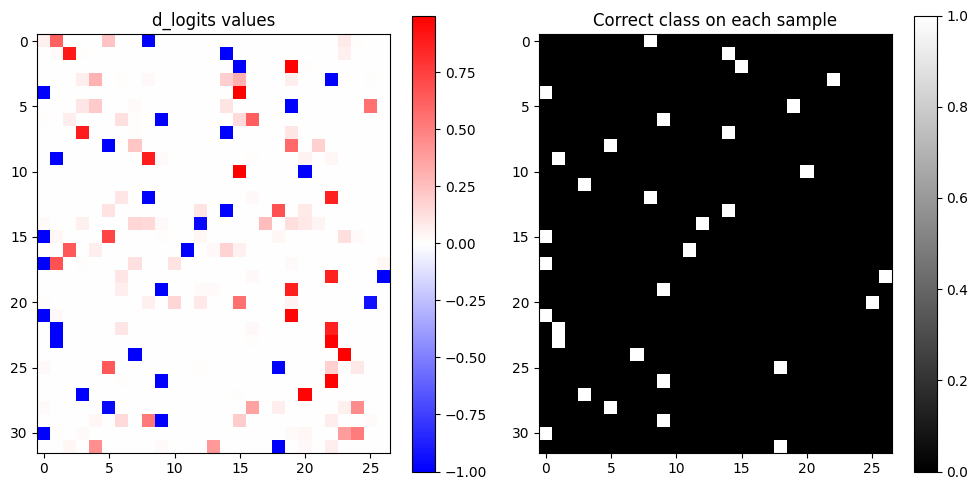

In [77]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Display the first image in the first subplot with "gray" colormap
img1 = axes[0].imshow(d_logits.detach()*n, cmap='bwr')
axes[0].set_title('d_logits values')
fig.colorbar(img1, ax=axes[0])  # Add colorbar (legend) for the first image

# Display the second image in the second subplot with "gray" colormap
img2 = axes[1].imshow(F.one_hot(Yb, num_classes=27), cmap='gray')
axes[1].set_title('Correct class on each sample')
fig.colorbar(img2, ax=axes[1])  # Add colorbar (legend) for the second image

# Show the plot
plt.tight_layout()
plt.show()

As we can see on each sample the most negative value for each gradient is for the element that reresent the correct token to predict. We can see this values as forces. On every row is like there is a rope, the absolute force on the rope is equal to 0, and every element is contributing with a given force. All the non label values contribute with a positive force and in the same way all the correct element contribute with a negative force. But the sum of all of them should cancel it, becauce as we have said is 0.

## Exercise 3

Derive the Batchnorm gradient calculation using the Math formula. First let see how the different tensors are related and how each one affect in the calculation of the others.

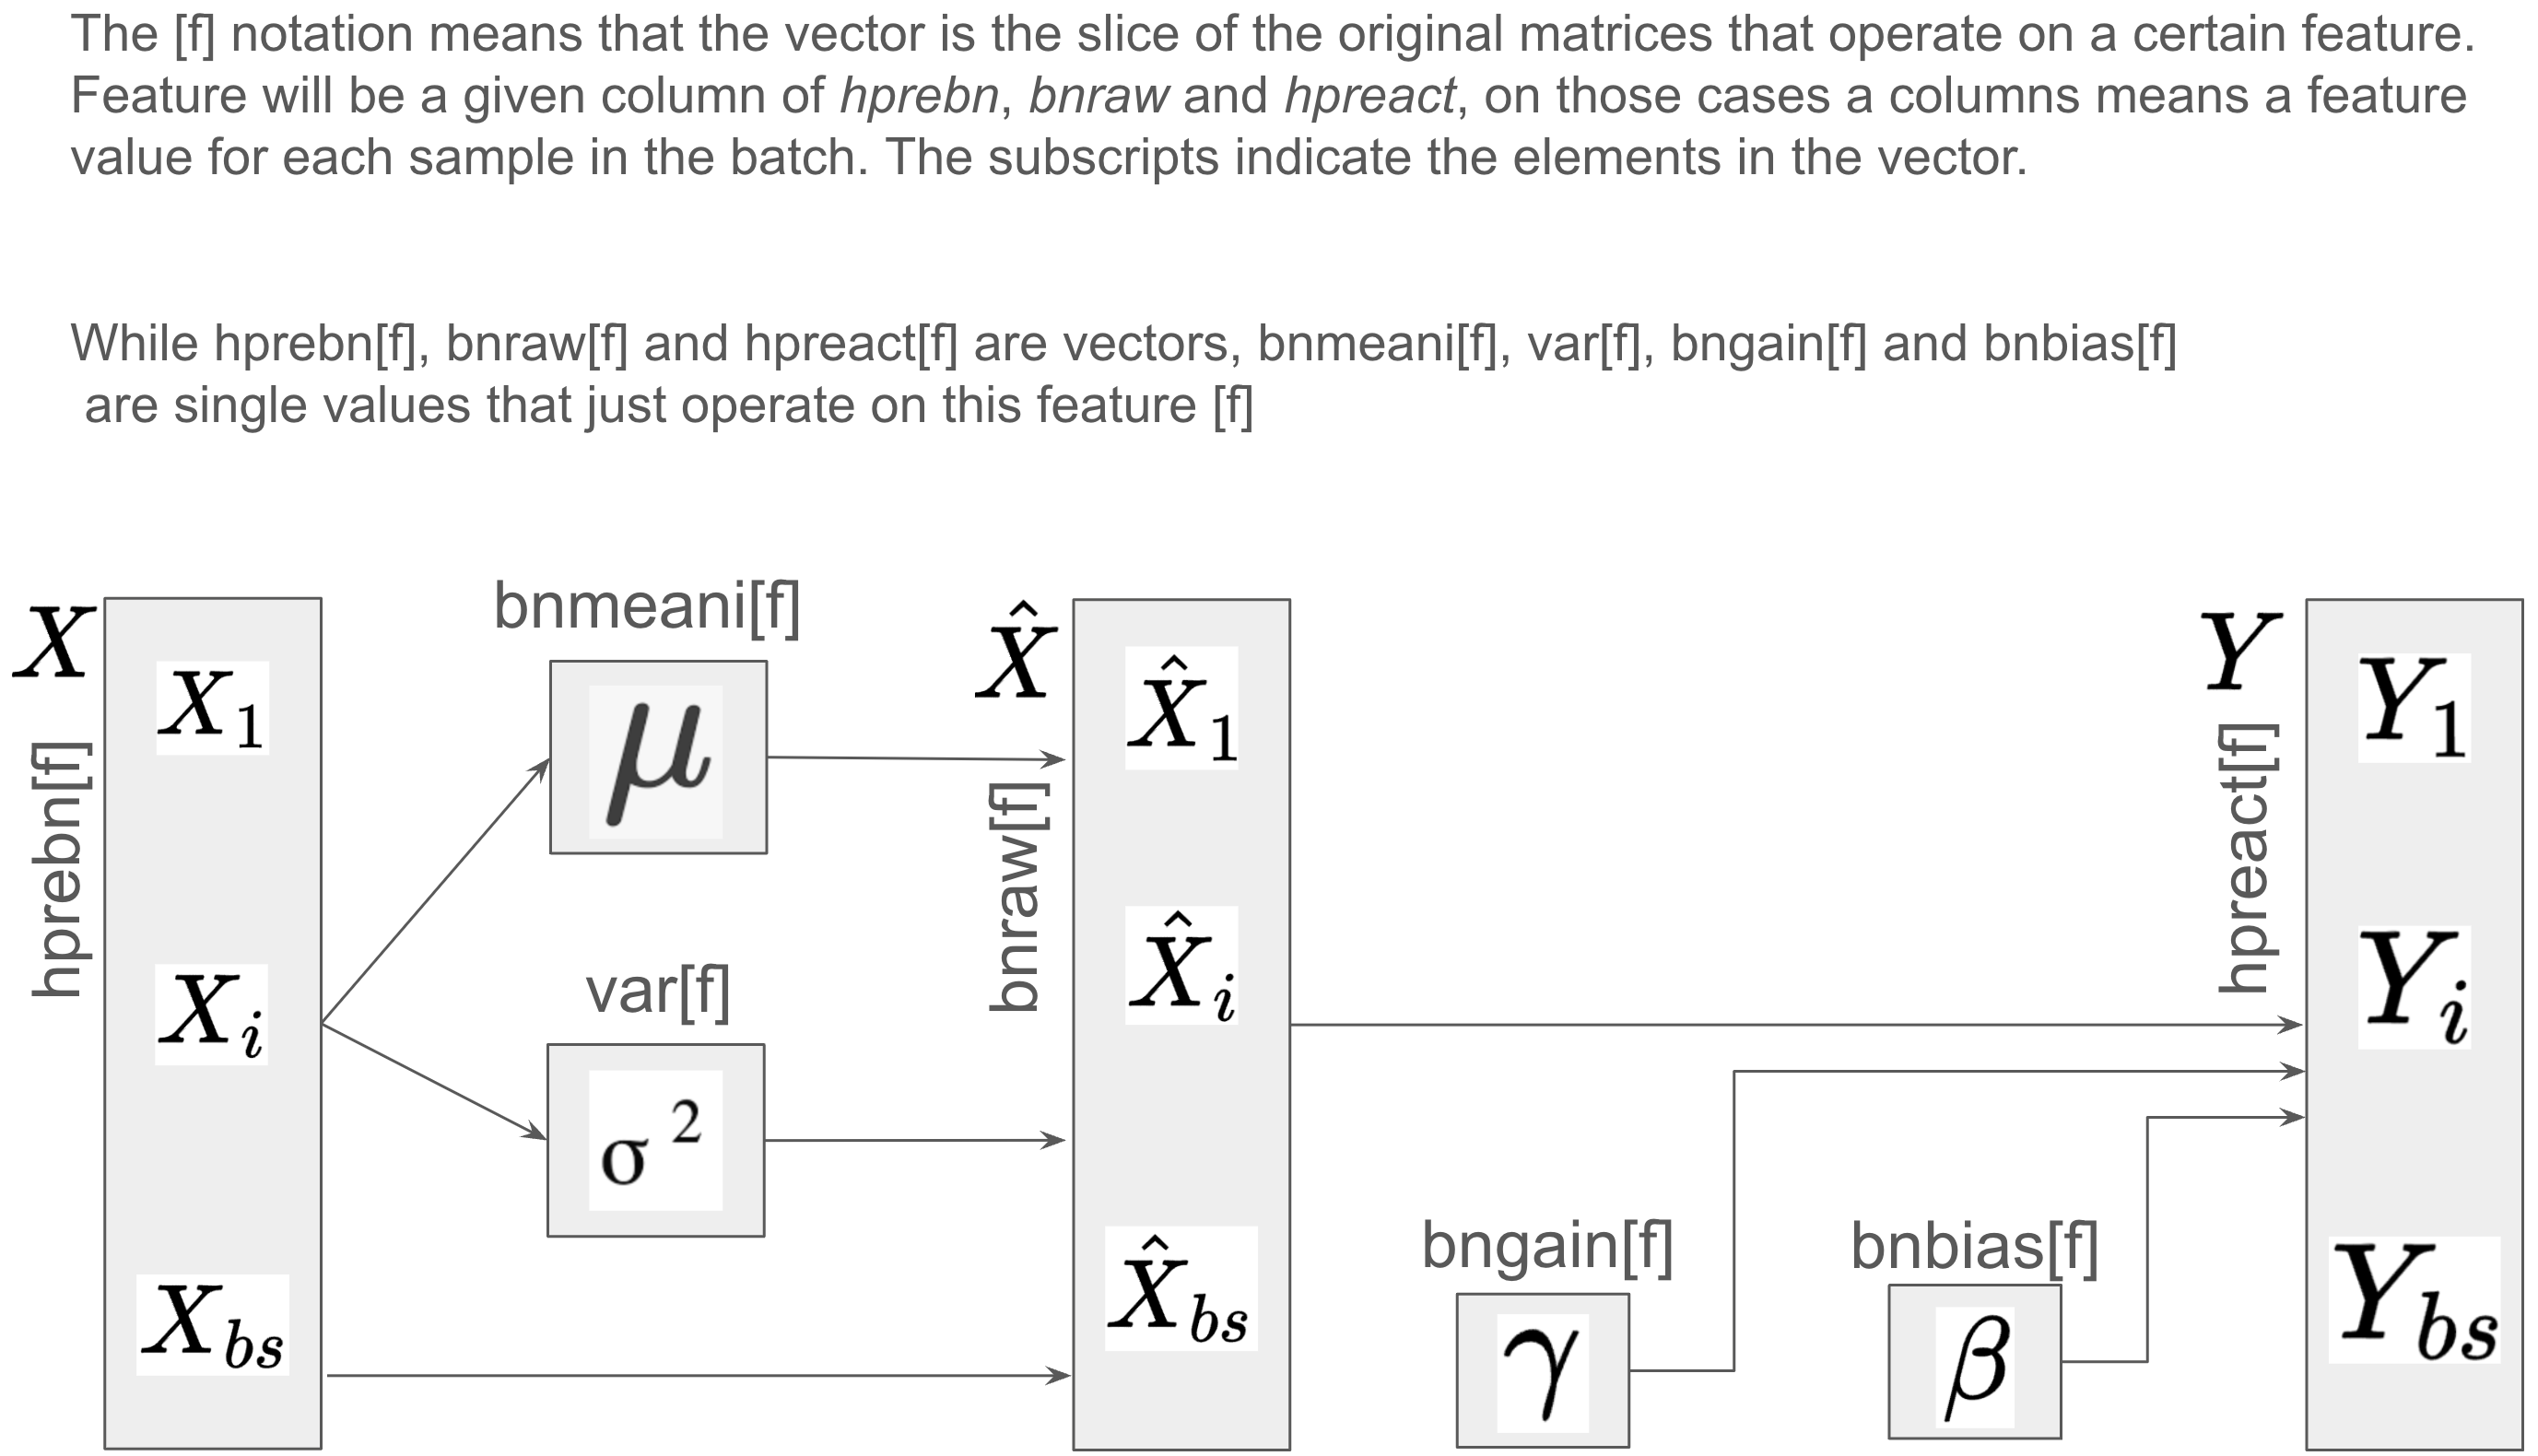


Lets check these formulas:

### Mean value
$
\mu = \frac{1}{m}*\sum_{i=1}^{n}x_i
$

### Variance value
$
\sigma^2 = \frac{1}{m-1}*\sum_{i=1}^{n}(x_i - \mu)^2
$

### Standarized values
$
\widehat{x}_i = \frac{x_i - \mu}{\sqrt{\sigma^2 + 𝛆}}
$

### Batchnormalized values
$
y_i = \gamma * \widehat{x}_i + \beta
$

We will assume the value $\frac{\partial Loss_{batch}}{\partial y_i}$ is known:

$
\frac{\partial Loss_{batch}}{\partial \widehat{x}_i} = \frac{\partial Loss_{batch}}{\partial y_i}*\frac{\partial y_i}{\partial \widehat{x}_i}=\frac{\partial Loss_{batch}}{\partial y_i}*\frac{\partial (\gamma * \widehat{x}_i + \beta)}{\partial \widehat{x}_i}=\frac{\partial Loss_{batch}}{\partial y_i}*\gamma
$

So we are simply saying that the element $y_i$ in $y$ varies $\gamma$ when the corresponding $\widehat{x}_i$ varies. In this case we do not think too much in shapes or how the gradient propagates because every element $\widehat{x}_i$ in $\widehat{x}$ only affects to the corresponding element $y_i$ in $y$.



Now lets calculate $\frac{\partial Loss_{total}}{\partial \sigma^2}$.

There is one thing that we need to take into account: As we have seen in the previous diagram $\sigma^2$ is a single value that affect to all the elements in $\widehat{x}$ so we need to sum up all the contributions when we calculate $\frac{\partial Loss_{total}}{\partial \sigma^2}$.

$
\frac{\partial Loss_{total}}{\partial \sigma^2} = \sum_{i=1}^{batch\_size} (\frac{\partial Loss_{total}}{\partial \widehat{x}_i}*\frac{\partial \widehat{x}_i}{\partial \sigma^2})=\\
\gamma*\sum_{i=1}^{batch\_size}(\frac{\partial Loss_{total}}{\partial y_i} * \frac{\partial \frac{x_i - \mu}{\sqrt{\sigma^2 + 𝛆}}}{\partial \sigma^2})=\\
\gamma*\sum_{i=1}^{batch\_size}(\frac{\partial Loss_{total}}{\partial y_i} * \frac{\partial (x_i - \mu)*(\sigma^2 + 𝛆)^{-\frac{1}{2}}}{\partial \sigma^2})=\\\gamma*\sum_{i=1}^{batch\_size}(\frac{\partial Loss_{total}}{\partial y_i} * (-\frac{1}{2})(x_i - \mu)*(\sigma^2 + 𝛆)^{-\frac{3}{2}}) = \\
\gamma(-\frac{1}{2})*\sum_{i=1}^{batch\_size}(\frac{\partial Loss_{total}}{\partial y_i} * (x_i - \mu)*(\sigma^2 + 𝛆)^{-\frac{3}{2}})
$

___

Now lets calculate $\frac{\partial Loss_{total}}{\partial \mu}$.

Here we have a similar situation that the previous one: we have a single value (for this feature, there will be other for other features) that affect to all the elements in $\widehat{x}_i$ so we need to sum up all the contributions:



$\mu$ have tow contrbutions so we will need to add both derivatives:
* The contribution in $\widehat{x}$
* The contribution in $\sigma^2$


Lets start with the contribution to $\widehat{x}$

$
\frac{\partial Loss_{total}}{\partial \mu_{\widehat{x}}} = \sum_{i=1}^{batch\_size} (\frac{\partial Loss_{total}}{\partial \widehat{x}_i}*\frac{\partial \widehat{x}_i}{\partial \mu})=\\
\gamma*\sum_{i=1}^{batch\_size}(\frac{\partial Loss_{total}}{\partial y_i} * \frac{\partial \frac{x_i - \mu}{\sqrt{\sigma^2 + 𝛆}}}{\partial \mu})=\\
\gamma*\sum_{i=1}^{batch\_size}(\frac{\partial Loss_{total}}{\partial y_i} * \frac{\partial (x_i - \mu)*(\sigma^2 + 𝛆)^{-\frac{1}{2}}}{\partial \sigma^2})=\\\gamma*\sum_{i=1}^{batch\_size}(\frac{\partial Loss_{total}}{\partial y_i} * (-1)*(\sigma^2 + 𝛆)^{-\frac{1}{2}}) = \\
-\gamma*\sum_{i=1}^{batch\_size}(\frac{\partial Loss_{total}}{\partial y_i} * (\sigma^2 + 𝛆)^{-\frac{1}{2}})
$

Lets start with the contribution to $\sigma^2$

$
\frac{\partial Loss_{batch}}{\partial \mu_{\sigma^2}} = \sum_{i=1}^{batch\_size} (\frac{\partial Loss_{batch}}{\partial \sigma^2}*\frac{\partial \sigma^2}{\partial \mu_{\sigma^2}})=\\
\gamma*\sum_{i=1}^{batch\_size}(\frac{\partial Loss_{batch}}{\partial \sigma^2} * \frac{\partial \frac{1}{m-1}*\sum_{i=1}^{n}(x_i - \mu)^2}{\partial \mu_{\sigma^2}})
$

Lets focus for a moment in the last part of the equation and expand it to see if we can simplify it:

$
\frac{1}{m-1}*\sum_{i=1}^{n}(x_i - \mu)^2 = \frac{1}{m-1}*\left[  (x_0 - \mu)^2 + ... +  (x_n - \mu)^2 \right] = \frac{1}{m-1}*\left[  (x_0 - \mu)^2 + ... +  (x_n - \mu)^2 \right]
$

Then:

$
\frac{\partial \sigma^2}{\partial \mu_{\sigma^2}} =\frac{1}{m-1}*\left[  -2*(x_0 - \mu) - ... -  2*(x_n - \mu) \right] =\\
 \frac{-2}{m-1}*\left[  \sum_{i=1}^{n}(x_i) - \sum_{i=1}^{n}(\mu) \right]
$

Now because:

$
\mu = \frac{1}{m}*\sum_{i=1}^{n}x_i \\
\sum_{i=1}^{n}x_i = \mu * m
$

In our case $m=n$, both represent the number of samples. So we can replace in the previous equation:

$
\frac{-2}{m-1}*\left[  \sum_{i=1}^{n}(x_i) - \sum_{i=1}^{n}(\mu) \right]=\frac{-2}{m-1}\left[ (\mu * m) - (m*\mu) \right] = 0
$

So:

$
\frac{\partial \sigma^2}{\partial \mu_{\sigma^2}} = 0
$


Then that we now both contributions we can calculate the total gradient for $\mu$:

$
\frac{\partial Loss_{batch}}{\partial \mu} = \frac{\partial Loss_{batch}}{\partial \mu_{\widehat{x}}} + \frac{\partial Loss_{batch}}{\partial \mu_{\sigma^2}} = -\gamma*\sum_{i=1}^{batch\_size}(\frac{\partial Loss_{batch}}{\partial y_i} * (\sigma^2 + 𝛆)^{-\frac{1}{2}})  + 0
$


Now its time to calculate $\frac{\partial Loss_{batch}}{\partial x}$. This derivative will have 3 different contributions:
* W.r.t. $\mu$
* W.r.t. $\widehat{x}$
* W.r.t. $\sigma^2$

So:

$
\frac{\partial Loss_{batch}}{\partial x} = \frac{\partial Loss_{batch}}{\partial x_{\mu}} + \frac{\partial Loss_{batch}}{\partial x} + \frac{\partial Loss_{batch}}{\partial x_{\sigma^2}} = \frac{\partial Loss_{batch}}{\partial \mu} * \frac{\partial \mu}{\partial x_{\mu}} + \frac{\partial Loss_{batch}}{\partial \widehat{x}} * \frac{\partial \widehat{x}}{\partial x_{\widehat{x}}} + \frac{\partial Loss_{batch}}{\partial \sigma^2} * \frac{\partial \sigma^2}{\partial x_{\sigma^2}}
$

Lets expand each one of the previous expressions:

$
\frac{\partial Loss_{batch}}{\partial \mu} =  -\gamma*\sum_{j=1}^{batch\_size}(\frac{\partial Loss_{batch}}{\partial y_j} * (\sigma^2 + 𝛆)^{-\frac{1}{2}})
$

$
\frac{\partial \mu}{\partial x_{\mu}} = \frac{1}{m}
$

$
\frac{\partial Loss_{batch}}{\partial \widehat{x}} = \frac{\partial Loss_{total}}{\partial y_i}*\gamma
$

$
\frac{\partial \widehat{x}}{\partial x_{\widehat{x}}} = (\sigma^2 + 𝛆)^{-\frac{1}{2}}
$

$
\frac{\partial Loss_{batch}}{\partial x_{\sigma^2}} = \gamma(-\frac{1}{2})*\sum_{j=1}^{batch\_size}(\frac{\partial Loss_{total}}{\partial y_j} * (x_j - \mu)*(\sigma^2 + 𝛆)^{-\frac{3}{2}})
$

$
\frac{\partial \sigma^2}{\partial x_{\sigma^2}} = \frac{2}{m-1}*(x_i - \mu)
$

The entire expression is:

$
\frac{\partial Loss_{batch}}{\partial x} = \gamma*\frac{\partial Loss_{total}}{\partial y_i} * (\sigma^2 + 𝛆)^{-\frac{1}{2}} + -\gamma*\sum_{j=1}^{batch\_size}(\frac{\partial Loss_{batch}}{\partial y_j} * (\sigma^2 + 𝛆)^{-\frac{1}{2}})*\frac{1}{m} + \gamma(-\frac{1}{2})*\sum_{j=1}^{batch\_size}(\frac{\partial Loss_{total}}{\partial y_j} * (x_j - \mu)*(\sigma^2 + 𝛆)^{-\frac{3}{2}})*\frac{2}{m-1}*(x_i - \mu)
$

Now cancel some two $2$s:

$
\frac{\partial Loss_{batch}}{\partial x} = \gamma*\frac{\partial Loss_{total}}{\partial y_i} * (\sigma^2 + 𝛆)^{-\frac{1}{2}} + -\gamma*\sum_{j=1}^{batch\_size}(\frac{\partial Loss_{batch}}{\partial y_j} * (\sigma^2 + 𝛆)^{-\frac{1}{2}})*\frac{1}{m} + \gamma(-1)*\sum_{j=1}^{batch\_size}(\frac{\partial Loss_{total}}{\partial y_j} * (x_j - \mu)*(\sigma^2 + 𝛆)^{-\frac{3}{2}})*\frac{1}{m-1}*(x_i - \mu)
$

Relocate the $(\sigma^2 + 𝛆)^{-\frac{1}{2}}$ terms:

$
\frac{\partial Loss_{batch}}{\partial x} = (\sigma^2 + 𝛆)^{-\frac{1}{2}}*(\gamma*\frac{\partial Loss_{total}}{\partial y_i}) + (\sigma^2 + 𝛆)^{-\frac{1}{2}}*(-\frac{1}{m}*\sum_{j=1}^{batch\_size}(\frac{\partial Loss_{batch}}{\partial y_j}*\gamma) + (\sigma^2 + 𝛆)^{-\frac{1}{2}}*(-\gamma)*\sum_{j=1}^{batch\_size}(\frac{\partial Loss_{total}}{\partial y_j} * (x_j - \mu)*(\sigma^2 + 𝛆)^{-\frac{1}{2}})*\frac{1}{m-1}*(x_i - \mu)
$

Now taken into account that $\widehat{x}_i=\frac{x_i - \mu}{\sqrt{\gamma^2+ε}}$ we can make some replacements in the previous formula:

$
\frac{\partial Loss_{batch}}{\partial x} = \\
\frac{{\sigma^2 + 𝛆}^{-\frac{1}{2}}}{m}*\left[ m*\gamma*\frac{\partial Loss_{total}}{\partial y_i} -\sum_{j=1}^{batch\_size}(\frac{\partial Loss_{batch}}{\partial y_j}*\gamma) -\gamma*\sum_{j=1}^{batch\_size}(\frac{\partial Loss_{total}}{\partial y_j}*\widehat{x}_j)*\frac{m}{m-1}*\widehat{x}_i\right] = \\
\gamma*\frac{{\sigma^2 + 𝛆}^{-\frac{1}{2}}}{m}*\left[ m*\frac{\partial Loss_{total}}{\partial y_i} -\sum_{j=1}^{batch\_size}(\frac{\partial Loss_{batch}}{\partial y_j}) -\sum_{j=1}^{batch\_size}(\frac{\partial Loss_{total}}{\partial y_j}*\widehat{x}_j)*\frac{m}{m-1}*\widehat{x}_i\right]
$

Now that we have derived the equation analitically we should implement it using the tensors. Let see how this work on each term:

* ${\sigma^2 + 𝛆}^{-\frac{1}{2}}$ = `bnvar_inv`
* $\gamma$ = `bngain`
* $m$ = `n` = `batch_size`
* $\frac{\partial Loss_{total}}{\partial y_i}$ = `d_hpreact`
* $\widehat{x}$ =

In [87]:
d_hprebn = bngain * (bnvar_inv / n) *  (n*d_hpreact - d_hpreact.sum(0) - (d_hpreact*bnraw).sum(0) * (n/(n-1))*bnraw)

In [88]:
cmp('d_hprebn', d_hprebn, hprebn)

d_hprebn        | exact: False | approximate: True  | maxdiff: 1.4901161193847656e-08


# Backward pytorch vs Manual Backprop application

In [94]:
n_embd = 10
n_hidden = 200
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((VOCABULARY_SIZE, n_embd), generator = g)
W1 = torch.randn((n_embd * BLOCK_SIZE, n_hidden), generator=g) * (5/3)/((n_embd * BLOCK_SIZE)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
W2 = torch.randn((n_hidden, VOCABULARY_SIZE),     generator=g) * 0.1
b2 = torch.randn(VOCABULARY_SIZE,                 generator=g) * 0.1

bngain = torch.randn(1, n_hidden) * 0.1 + 1.0
bnbias = torch.randn(1, n_hidden) * 0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print("Trainable params:",sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True


lossi = []

for i in range(20000):

  batch_ixs = torch.randint(low=0,high=Ytr.shape[0], size=(n,), generator = g)
  Xb, Yb = Xtr[batch_ixs], Ytr[batch_ixs]

    # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hprebn = embcat @ W1 + b1 # hidden layer pre-activation
  # BatchNorm layer
  # -------------------------------------------------------------
  bnmean = hprebn.mean(0, keepdim=True)
  bnvar = hprebn.var(0, keepdim=True, unbiased=True)
  bnvar_inv = (bnvar + 1e-5)**-0.5
  bnraw = (hprebn - bnmean) * bnvar_inv
  hpreact = bngain * bnraw + bnbias
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function


  for p in parameters:
    p.grad = None

  loss.backward()

  lr = 0.1 if i < 10000 else 0.01
  for p in parameters:
    p.data -= p.grad*lr

  if i%2000==0:
    print(i,loss.item())

Trainable params: 12297
0 3.764800786972046
2000 2.2978720664978027
4000 2.1656999588012695
6000 2.146484613418579
8000 2.0388946533203125
10000 2.188335418701172
12000 2.2148616313934326
14000 2.6283795833587646
16000 2.391542673110962
18000 2.0529062747955322


In [13]:
n_embd = 10
n_hidden = 200
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((VOCABULARY_SIZE, n_embd), generator = g)
W1 = torch.randn((n_embd * BLOCK_SIZE, n_hidden), generator=g) * (5/3)/((n_embd * BLOCK_SIZE)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
W2 = torch.randn((n_hidden, VOCABULARY_SIZE),     generator=g) * 0.1
b2 = torch.randn(VOCABULARY_SIZE,                 generator=g) * 0.1

bngain = torch.randn(1, n_hidden) * 0.1 + 1.0
bnbias = torch.randn(1, n_hidden) * 0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print("Trainable params:",sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True


lossi = []

for i in range(20000):

  batch_ixs = torch.randint(low=0,high=Ytr.shape[0], size=(n,), generator = g)
  Xb, Yb = Xtr[batch_ixs], Ytr[batch_ixs]

    # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hprebn = embcat @ W1 + b1 # hidden layer pre-activation
  # BatchNorm layer
  # -------------------------------------------------------------
  bnmean = hprebn.mean(0, keepdim=True)
  bnvar = hprebn.var(0, keepdim=True, unbiased=True)
  bnvar_inv = (bnvar + 1e-5)**-0.5
  bnraw = (hprebn - bnmean) * bnvar_inv
  hpreact = bngain * bnraw + bnbias
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function


  for p in parameters:
    p.grad = None


  ##################################################
  probabilities = F.softmax(logits, dim=1)
  probabilities[range(n), Yb] -= 1
  dlogits = probabilities*(1.0/n)

  dh = dlogits @ W2.T
  dW2 = h.T @ dlogits
  db2 = dlogits.sum(0)
  dhpreact = dh * (1.0-(h**2))
  dbnraw = dhpreact * bngain
  dbngain = (dhpreact * bnraw).sum(0, keepdim=True)
  dbnbias = dhpreact.sum(0, keepdim=True)
  dhprebn = bngain * (bnvar_inv / n) *  (n*dhpreact - dhpreact.sum(0) - (dhpreact*bnraw).sum(0) * (n/(n-1))*bnraw)
  dembcat = dhprebn @ W1.T
  dW1 = embcat.T @ dhprebn
  db1 = dhprebn.sum(0)
  demb = dembcat.view(32, 3, 10)
  dC =  torch.zeros_like(C)
  for sample_ix in range(batch_size):
    for block_ix in range(BLOCK_SIZE):
      dC[Xb[sample_ix][block_ix]] += demb[sample_ix][block_ix]
  ##################################################

  #dC, dW1, db1, dW2, db2, dbngain, dbnbias = None, None, None, None, None, None, None
  grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]

  lr = 0.1 if i < 10000 else 0.01
  for p,grad in zip(parameters,grads):
    p.data -= grad*lr

  if i%2000==0:
    print(i,loss.item())

Trainable params: 12297
0 3.7432291507720947
2000 2.3081319332122803
4000 2.2144863605499268
6000 2.127002239227295
8000 2.012110710144043
10000 2.1705288887023926
12000 2.2521204948425293
14000 2.652254343032837
16000 2.341482639312744
18000 2.0540854930877686


As we can see we get similar results with both approaches. So our manual implementation is a success!

Finally we are going to evaluate our model in the test split. To do this we need first calibrate the model. It means to calculate de `bnmean` and `bnvar` that we will use in the test stage.

In [17]:
with torch.no_grad():
  emb = C[Xtr] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hprebn = embcat @ W1 + b1 # hidden layer pre-activation
  # BatchNorm layer
  # -------------------------------------------------------------
  bnmean = hprebn.mean(0, keepdim=True)
  bnvar = hprebn.var(0, keepdim=True, unbiased=True)

In [19]:
# evaluate train and val loss

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev)
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.1872878074645996
val 2.1966140270233154


And to end the notebook we will sample from the model to see what names it generates:

In [21]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * BLOCK_SIZE # initialize with all ...
    while True:
      # forward pass
      emb = C[torch.tensor([context])] # (1,block_size,d)
      embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
      hpreact = embcat @ W1 + b1
      hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
      h = torch.tanh(hpreact) # (N, n_hidden)
      logits = h @ W2 + b2 # (N, vocab_size)
      # sample
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

mria.
kayah.
seel.
ndyn.
alarethricendraeg.
adelyn.
elin.
shi.
jen.
eden.
estanaraelyn.
malara.
noshibergihi.
jest.
jair.
jelilanthona.
ubelled.
ruy.
julieh.
ylae.
